In [27]:
import yfinance as yf
import pandas as pd
import numpy as np

# 이더리움 티커 심볼
ticker = 'ETH-USD'

# 데이터 수집 기간 설정
start_date = '2024-11-04'
end_date = '2024-11-09'

# 데이터 다운로드
eth_data = yf.download(ticker, start=start_date, end=end_date, interval='1m')
print()
# 데이터 확인
print(eth_data.tail(),eth_data.shape)

[*********************100%***********************]  1 of 1 completed


Price                        Adj Close        Close         High          Low  \
Ticker                         ETH-USD      ETH-USD      ETH-USD      ETH-USD   
Datetime                                                                        
2024-11-08 23:52:00+00:00  2958.916992  2958.916992  2958.916992  2958.916992   
2024-11-08 23:53:00+00:00  2960.293457  2960.293457  2960.293457  2960.293457   
2024-11-08 23:54:00+00:00  2960.160400  2960.160400  2960.160400  2960.160400   
2024-11-08 23:55:00+00:00  2959.501953  2959.501953  2959.501953  2959.501953   
2024-11-08 23:57:00+00:00  2961.552979  2961.552979  2961.552979  2961.552979   

Price                             Open   Volume  
Ticker                         ETH-USD  ETH-USD  
Datetime                                         
2024-11-08 23:52:00+00:00  2958.916992        0  
2024-11-08 23:53:00+00:00  2960.293457        0  
2024-11-08 23:54:00+00:00  2960.160400  2222080  
2024-11-08 23:55:00+00:00  2959.501953        0  


In [28]:
# Splitting data into chunks of 1094 rows
chunk_size = 1094
chunk_eth = [eth_data[i:i + chunk_size] for i in range(0, len(eth_data), chunk_size)]

# Check the number of chunks and the first chunk
print(f"Number of chunks: {len(chunk_eth)}")

Number of chunks: 5


In [99]:
import matplotlib.pyplot as plt
import pandas as pd

def calculate_threshold(lower_band, upper_band, min_threshold=0.002, max_threshold=0.005):
    # lower_band와 upper_band의 차이를 계산
    range_value = upper_band - lower_band

    # 백분율로 환산하여 가중치를 계산 (예: 범위를 100으로 나눠서 비율을 구함)
    range_percentage = range_value / upper_band if upper_band != 0 else 0

    # 임계값 계산: min_threshold와 max_threshold 사이에서 동적으로 변함
    # range_percentage를 이용해 임계값을 스케일링함
    threshold = min_threshold + (max_threshold - min_threshold) * range_percentage

    # 임계값이 min_threshold와 max_threshold 사이에 있도록 보장
    threshold = max(min_threshold, min(threshold, max_threshold))

    return threshold

for chunk in range(len(chunk_eth)):
    print("-=================================================================")
    # 데이터 불러오기 (예시)
    data_chunk = chunk_eth[chunk].copy()

    # 이동 평균과 표준 편차 계산
    window = 20
    data_chunk[('Moving_Avg', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).mean()
    data_chunk[('Std_Dev', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).std()

    # NaN 제거 후 볼린저 밴드 계산
    data_chunk.dropna(inplace=True)
    data_chunk[('Upper_Band', 'ETH-USD')] = data_chunk[('Moving_Avg', 'ETH-USD')] + (data_chunk[('Std_Dev', 'ETH-USD')] * 2)
    data_chunk[('Lower_Band', 'ETH-USD')] = data_chunk[('Moving_Avg', 'ETH-USD')] - (data_chunk[('Std_Dev', 'ETH-USD')] * 2)

    close_to_upper = False
    close_to_lower = False


    # 매수 및 매도 전략 수행
    buy_signals = []  # 매수 지점
    sell_signals = []  # 매도 지점
    positions = []  # 각 시간에 따른 포지션 상태 저장 리스트
    position = 0  # 포지션 (1: 매수 상태, 0: 중립, -1: 매도 상태)

    profit = 0
    total_profit = 0
    buy_price = 0

    before_close_u = False
    before_close_l = False

    lower_close = []
    upper_close = []

    stock = []

    for i in range(len(data_chunk)):

        close_price = data_chunk.iloc[i][('Close', 'ETH-USD')]
        lower_band = data_chunk.iloc[i][('Lower_Band', 'ETH-USD')]
        upper_band = data_chunk.iloc[i][('Upper_Band', 'ETH-USD')]

        # 편차를 계산하여 근접 여부 판단
        deviation_threshold = calculate_threshold(lower_band, upper_band)

        lower_close.append(abs(close_price - lower_band) / abs(lower_band))
        upper_close.append(abs(close_price - upper_band) / abs(upper_band))


        # Lower_Band에 근접했는지 확인
        if abs(close_price - lower_band) / abs(lower_band) < deviation_threshold:
            close_to_lower = True
        else:
            close_to_lower = False

        # Upper_Band에 근접했는지 확인
        if abs(close_price - upper_band) / abs(upper_band) < deviation_threshold:
            close_to_upper = True
        else:
            close_to_upper = False

        # Lower_Band에 근접했다가 떨어지는 경우 매수
        if before_close_l and  not close_to_upper:# position == 0 and before_close_l and  not close_to_upper:
            #position = 1  # 매수
            buy_signals.append((data_chunk.index[i], close_price))
            print(f"Buy signal at index {data_chunk.index[i]} with value {close_price}", len(stock))
            buy_price = close_price
            before_close_l = False
            stock.append(close_price)
        # Upper_Band에 근접했다가 떨어지는 경우 매도
        elif before_close_u and  not close_to_lower and len(stock) > 0:#position == 1 and before_close_u and  not close_to_lower:
            #position = 0  # 매도
            max_value_index = stock.index(max(stock))
            s = stock.pop(max_value_index)
            sell_signals.append((data_chunk.index[i], close_price))
            profit = (close_price - s)
            total_profit += profit - (s * 0.0002)
            buy_price = 0

            print(f"Sell signal at index {data_chunk.index[i]} with value {close_price} for profit: {profit} total : {total_profit}")
            before_close_u = False
        # 포지션 중립 상태 유지

        # 포지션 저장
        positions.append(position)
        before_close_l = close_to_lower
        before_close_u = close_to_upper

    plt.figure(figsize=(30, 7))
    # 그래프 그리기
    plt.plot(data_chunk.index, data_chunk[('Close', 'ETH-USD')], label='Close Price', color='blue')
    plt.plot(data_chunk.index, data_chunk[('Moving_Avg', 'ETH-USD')], label='Moving Average', color='orange')
    plt.plot(data_chunk.index, data_chunk[('Upper_Band', 'ETH-USD')], label='Upper Bollinger Band', color='red')
    plt.plot(data_chunk.index, data_chunk[('Lower_Band', 'ETH-USD')], label='Lower Bollinger Band', color='green')
    plt.scatter(*zip(*buy_signals), color='magenta', label='Buy Signal', marker='^')  # 매수 지점 표시
    plt.scatter(*zip(*sell_signals), color='green', label='Sell Signal', marker='v')  # 매도 지점 표시
    plt.figure(figsize=(30, 7))
    plt.plot(data_chunk.index, upper_close , label='upper_close', color='red')
    plt.plot(data_chunk.index, lower_close , label='lower_close', color='blue')
    # 매수 및 매도 시그널 개수 출력
    print(f"Number of buy signals: {len(buy_signals)}")
    print(f"Number of sell signals: {len(sell_signals)}")

# 그래프 타이틀과 레이블
plt.title('Bollinger Bands with Original Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

Buy signal at index 2024-11-04 00:29:00+00:00 with value -4.908227539062409
Sell signal at index 2024-11-04 00:57:00+00:00 with value 7.315686035156432 for 12.223913574218841 total : 12.223913574218841
Buy signal at index 2024-11-04 04:04:00+00:00 with value -3.4495849609375
Sell signal at index 2024-11-04 04:29:00+00:00 with value 3.909619140625182 for 7.359204101562682 total : 19.583117675781523
Buy signal at index 2024-11-04 05:08:00+00:00 with value -3.353015136718568
Sell signal at index 2024-11-04 06:08:00+00:00 with value 3.65283203125 for 7.005847167968568 total : 26.58896484375009
Buy signal at index 2024-11-04 07:42:00+00:00 with value -7.76727294921875
Sell signal at index 2024-11-04 08:08:00+00:00 with value 3.035144042968568 for 10.802416992187318 total : 37.39138183593741
Buy signal at index 2024-11-04 08:36:00+00:00 with value -3.486108398437409
Sell signal at index 2024-11-04 09:12:00+00:00 with value 4.493237304687682 for 7.979345703125091 total : 45.3707275390625
Buy 

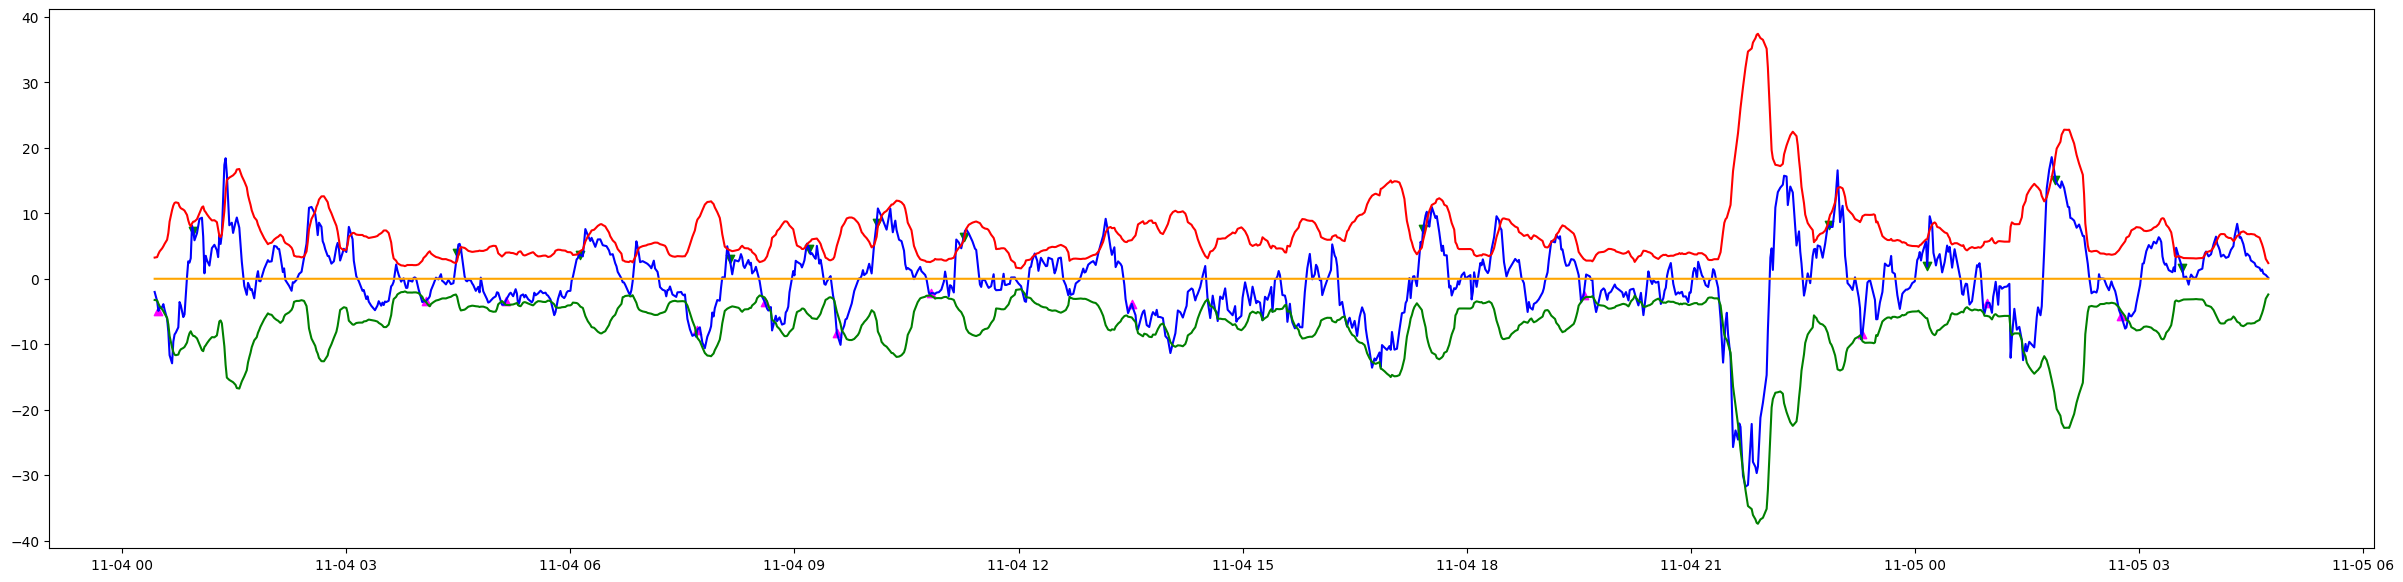

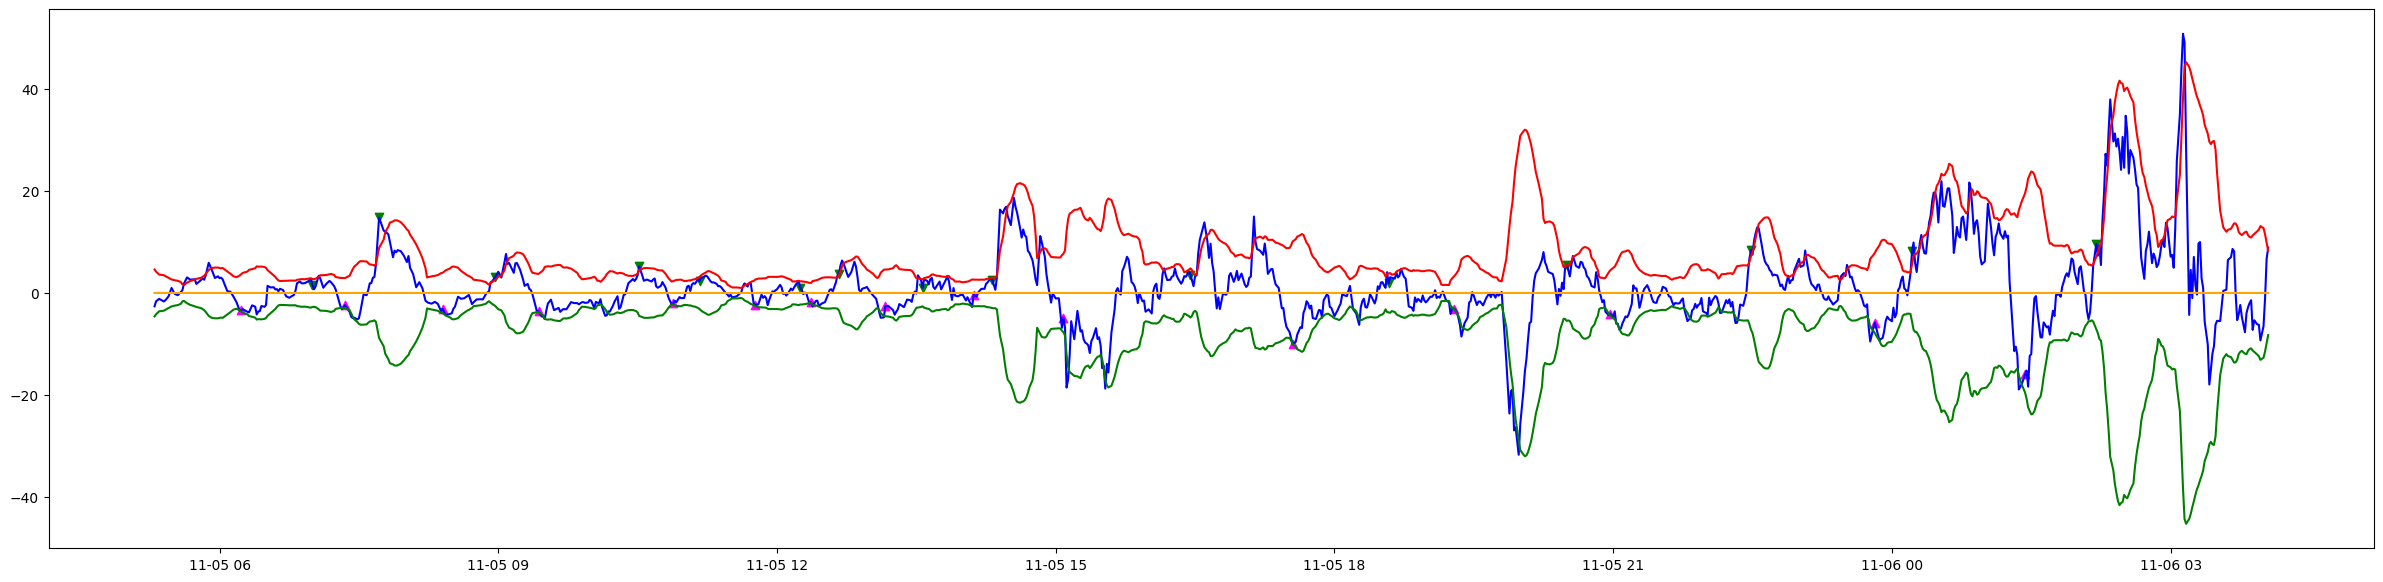

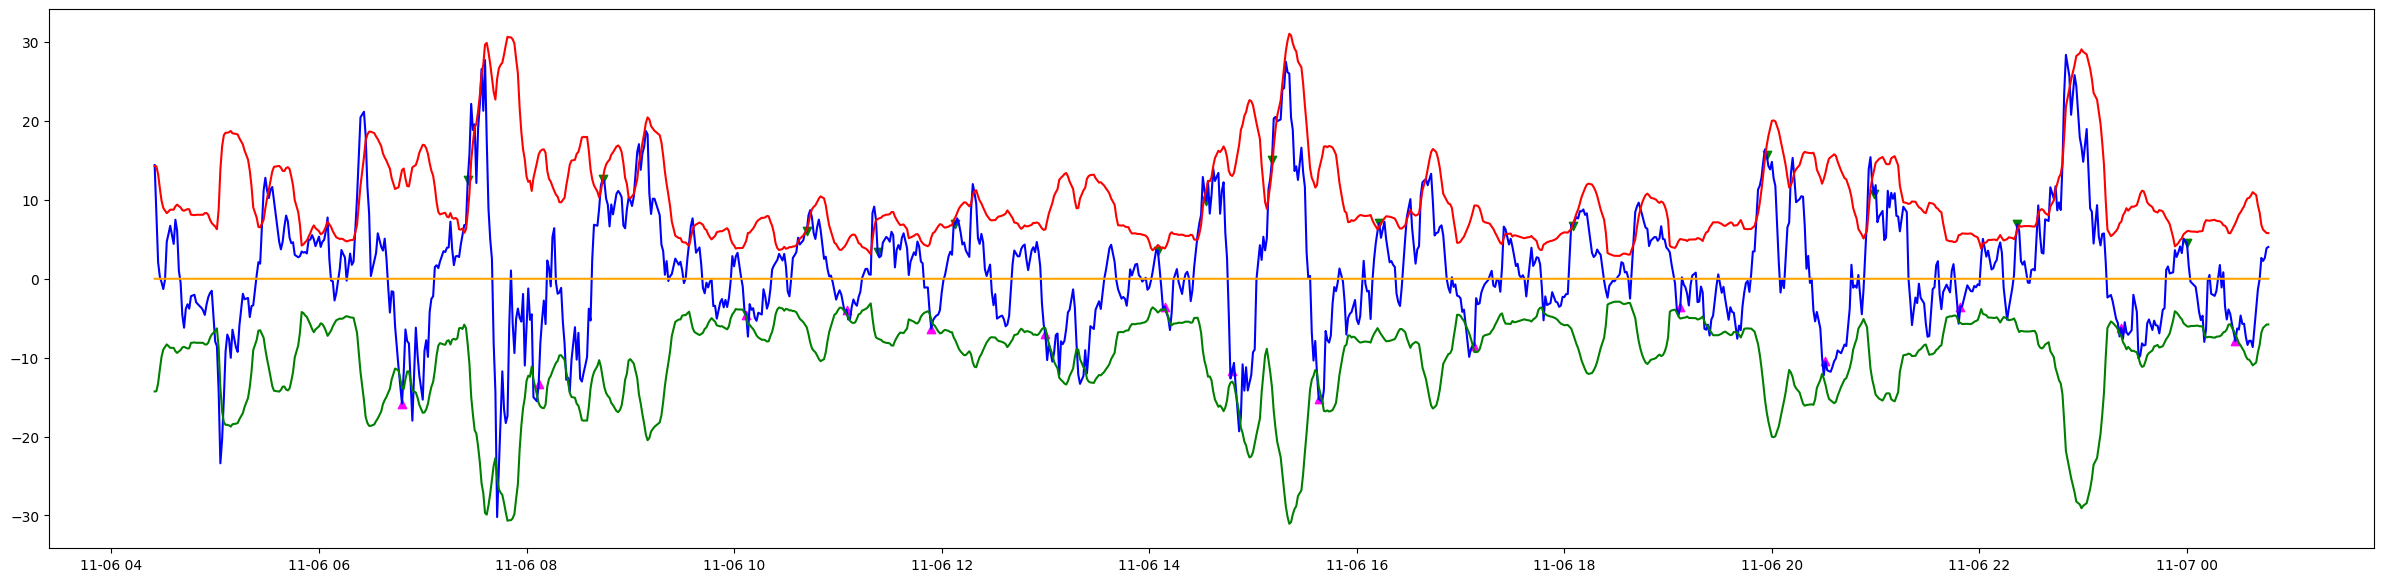

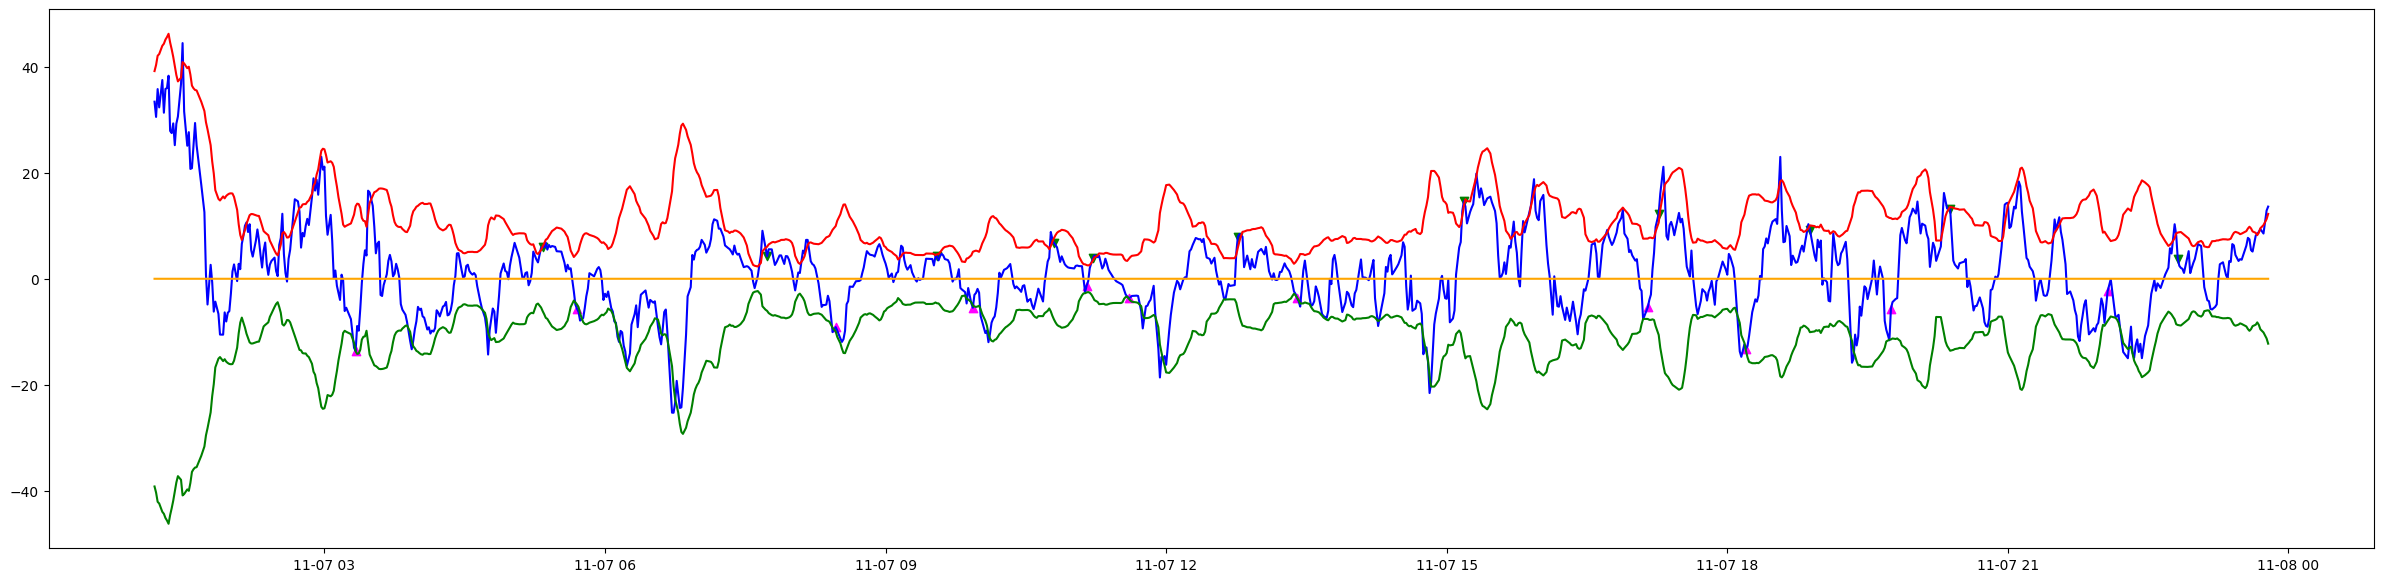

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


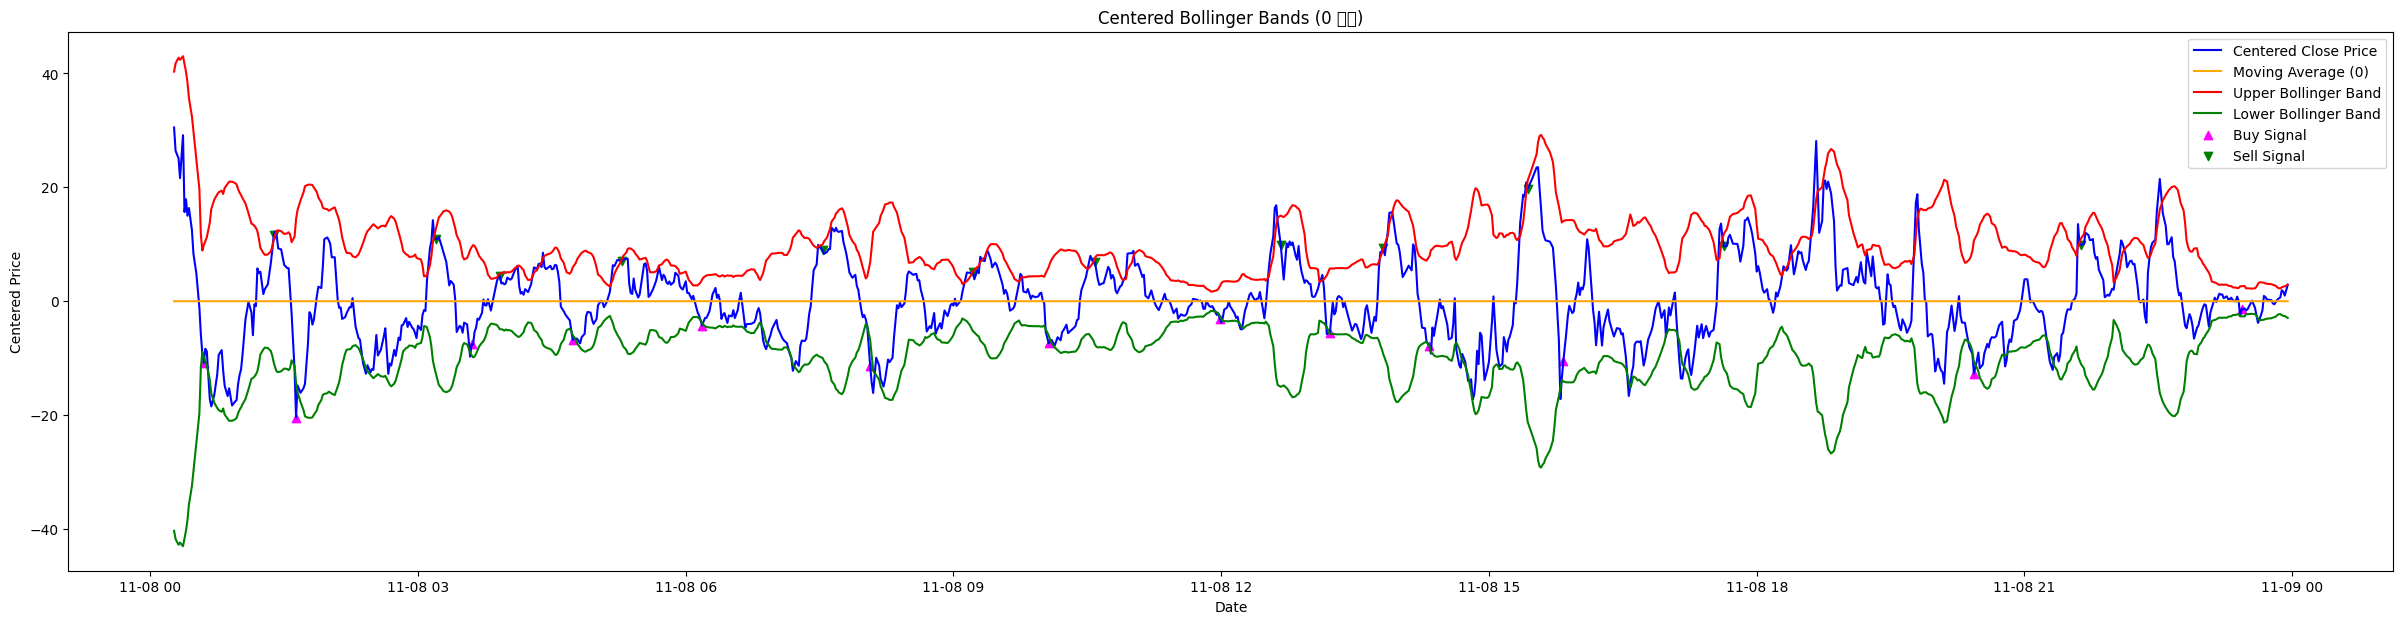

In [84]:
import matplotlib.pyplot as plt
import pandas as pd

for chunk in range(len(chunk_eth)):
    # 데이터 불러오기 (예시)
    data_chunk = chunk_eth[chunk].copy()

    # 이동 평균과 표준 편차 계산
    window = 20
    data_chunk[('Moving_Avg', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).mean()
    data_chunk[('Std_Dev', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).std()

    # NaN 제거 후 볼린저 밴드 0 기준으로 계산
    data_chunk.dropna(inplace=True)
    data_chunk[('Centered_Close', 'ETH-USD')] = data_chunk[('Close', 'ETH-USD')] - data_chunk[('Moving_Avg', 'ETH-USD')]  # Close에서 이동 평균을 뺀 값
    data_chunk[('Upper_Band', 'ETH-USD')] = data_chunk[('Std_Dev', 'ETH-USD')] * 2
    data_chunk[('Lower_Band', 'ETH-USD')] = -data_chunk[('Std_Dev', 'ETH-USD')] * 2

    close_to_upper = False
    close_to_lower = False

    # 매수 및 매도 전략 수행
    buy_signals = []  # 매수 지점
    sell_signals = []  # 매도 지점
    positions = []  # 각 시간에 따른 포지션 상태 저장 리스트
    position = 0  # 포지션 (1: 매수 상태, 0: 중립, -1: 매도 상태)

    profit = 0
    total_profit = 0
    buy_price = 0

    before_close_u = False
    before_close_l = False

    for i in range(len(data_chunk)):
        centered_close = data_chunk.iloc[i][('Centered_Close', 'ETH-USD')]
        lower_band = data_chunk.iloc[i][('Lower_Band', 'ETH-USD')]
        upper_band = data_chunk.iloc[i][('Upper_Band', 'ETH-USD')]

        # 편차를 계산하여 근접 여부 판단
        deviation_threshold = 0.1  # 편차 임계값 설정 (10%)

        # Lower_Band에 근접했는지 확인
        if abs(centered_close - lower_band) / abs(lower_band) < deviation_threshold:
            close_to_lower = True
        else:
            close_to_lower = False

        # Upper_Band에 근접했는지 확인
        if abs(centered_close - upper_band) / abs(upper_band) < deviation_threshold:
            close_to_upper = True
        else:
            close_to_upper = False

        # Lower_Band에 근접했다가 떨어지는 경우 매수
        if position == 0 and before_close_l and  not close_to_upper:
            position = 1  # 매수
            buy_signals.append((data_chunk.index[i], centered_close))
            print(f"Buy signal at index {data_chunk.index[i]} with value {centered_close}")
            buy_price = centered_close
        # Upper_Band에 근접했다가 떨어지는 경우 매도
        elif position == 1 and before_close_u and  not close_to_lower:
            position = 0  # 매도
            sell_signals.append((data_chunk.index[i], centered_close))
            profit = (centered_close - buy_price)
            total_profit += profit
            buy_price = 0
            print(f"Sell signal at index {data_chunk.index[i]} with value {centered_close} for {profit} total : {total_profit}")
        # 포지션 중립 상태 유지

        # 포지션 저장
        positions.append(position)

        before_close_l = close_to_lower
        before_close_u = close_to_upper

    plt.figure(figsize=(30, 7))
    # 그래프 그리기
    plt.plot(data_chunk.index, data_chunk[('Centered_Close', 'ETH-USD')], label='Centered Close Price', color='blue')
    plt.plot(data_chunk.index, [0] * len(data_chunk), label='Moving Average (0)', color='orange')
    plt.plot(data_chunk.index, data_chunk[('Upper_Band', 'ETH-USD')], label='Upper Bollinger Band', color='red')
    plt.plot(data_chunk.index, data_chunk[('Lower_Band', 'ETH-USD')], label='Lower Bollinger Band', color='green')
    plt.scatter(*zip(*buy_signals), color='magenta', label='Buy Signal', marker='^')  # 매수 지점 표시
    plt.scatter(*zip(*sell_signals), color='green', label='Sell Signal', marker='v')  # 매도 지점 표시

    # 매수 및 매도 시그널 개수 출력
    print(f"Number of buy signals: {len(buy_signals)}")
    print(f"Number of sell signals: {len(sell_signals)}")

# 그래프 타이틀과 레이블
plt.title('Centered Bollinger Bands (0 기준)')
plt.xlabel('Date')
plt.ylabel('Centered Price')
plt.legend(loc='best')
plt.show()


Buy signal at index 2024-11-04 00:32:00+00:00 with value -4.322338867187682
Sell signal at index 2024-11-04 00:56:00+00:00 with value 8.129589843750182 for 12.451928710937864 total : 12.451928710937864
Buy signal at index 2024-11-04 04:04:00+00:00 with value -3.4495849609375
Sell signal at index 2024-11-04 04:28:00+00:00 with value 2.33563232421875 for 5.78521728515625 total : 18.237145996094114
Buy signal at index 2024-11-04 05:18:00+00:00 with value -3.97540283203125
Sell signal at index 2024-11-04 06:07:00+00:00 with value 3.858190917968841 for 7.833593750000091 total : 26.070739746094205
Buy signal at index 2024-11-04 07:46:00+00:00 with value -9.733068847656341
Sell signal at index 2024-11-04 10:10:00+00:00 with value 9.511206054687591 for 19.244274902343932 total : 45.31501464843814
Buy signal at index 2024-11-04 10:49:00+00:00 with value -2.409924316406432
Sell signal at index 2024-11-04 11:14:00+00:00 with value 4.657885742187318 for 7.06781005859375 total : 52.38282470703189
B

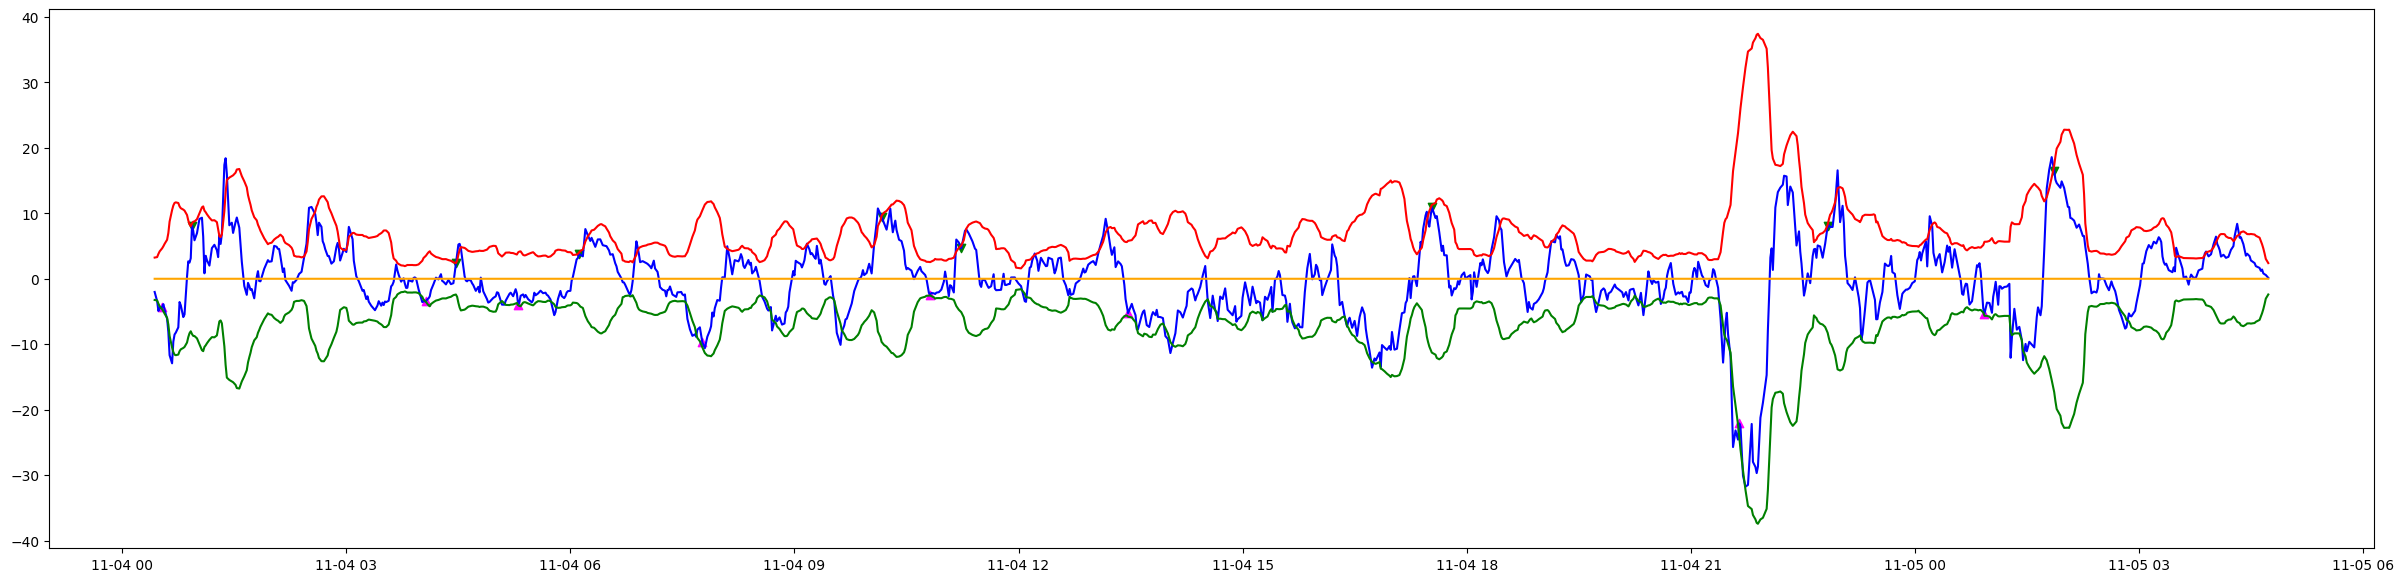

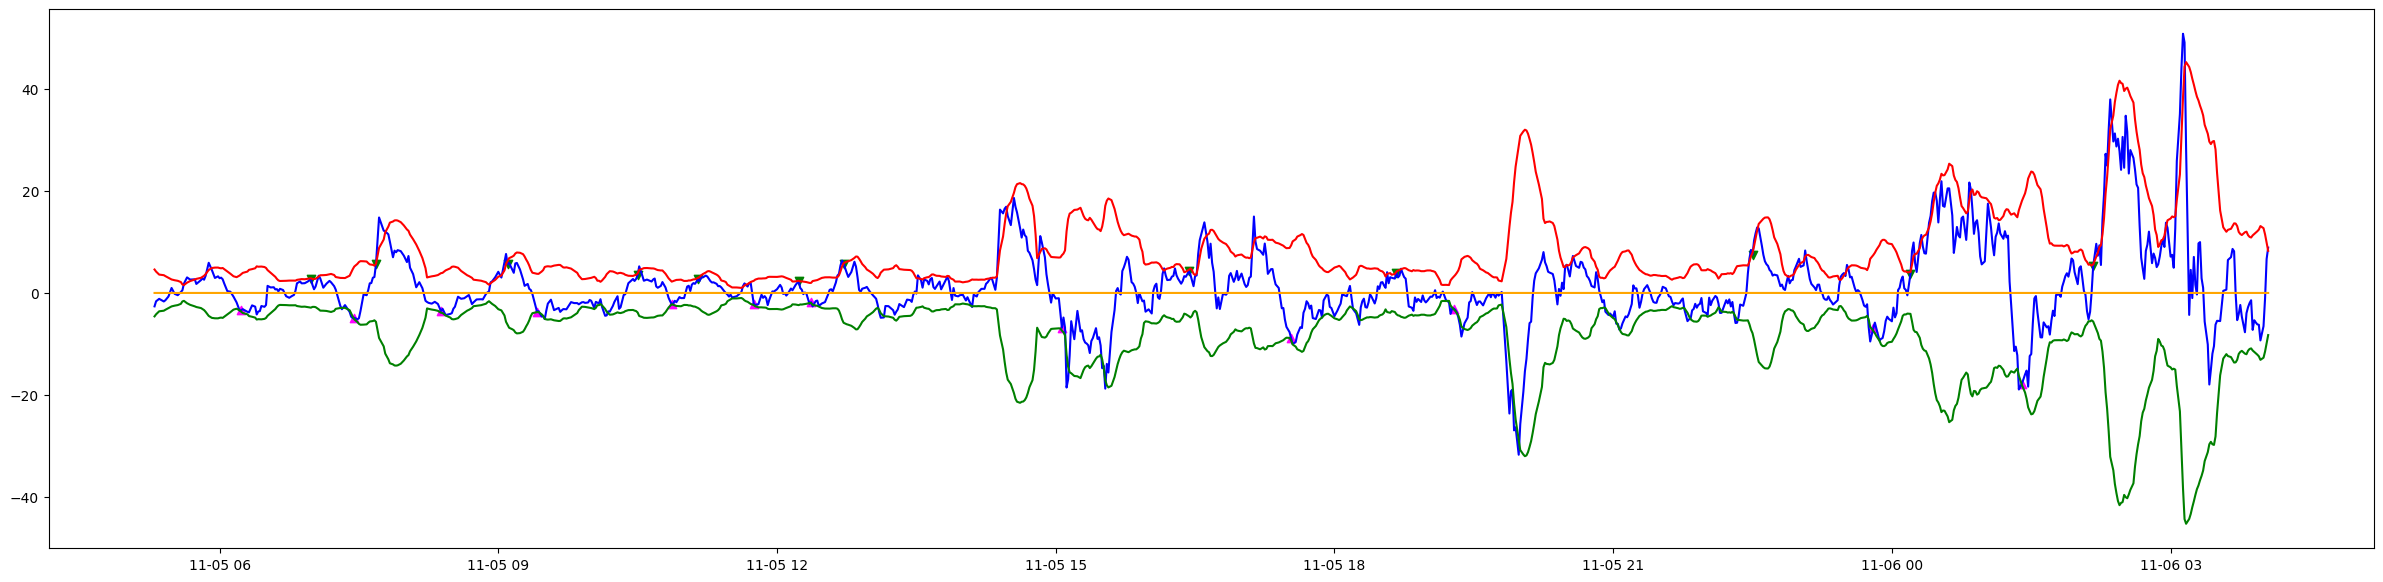

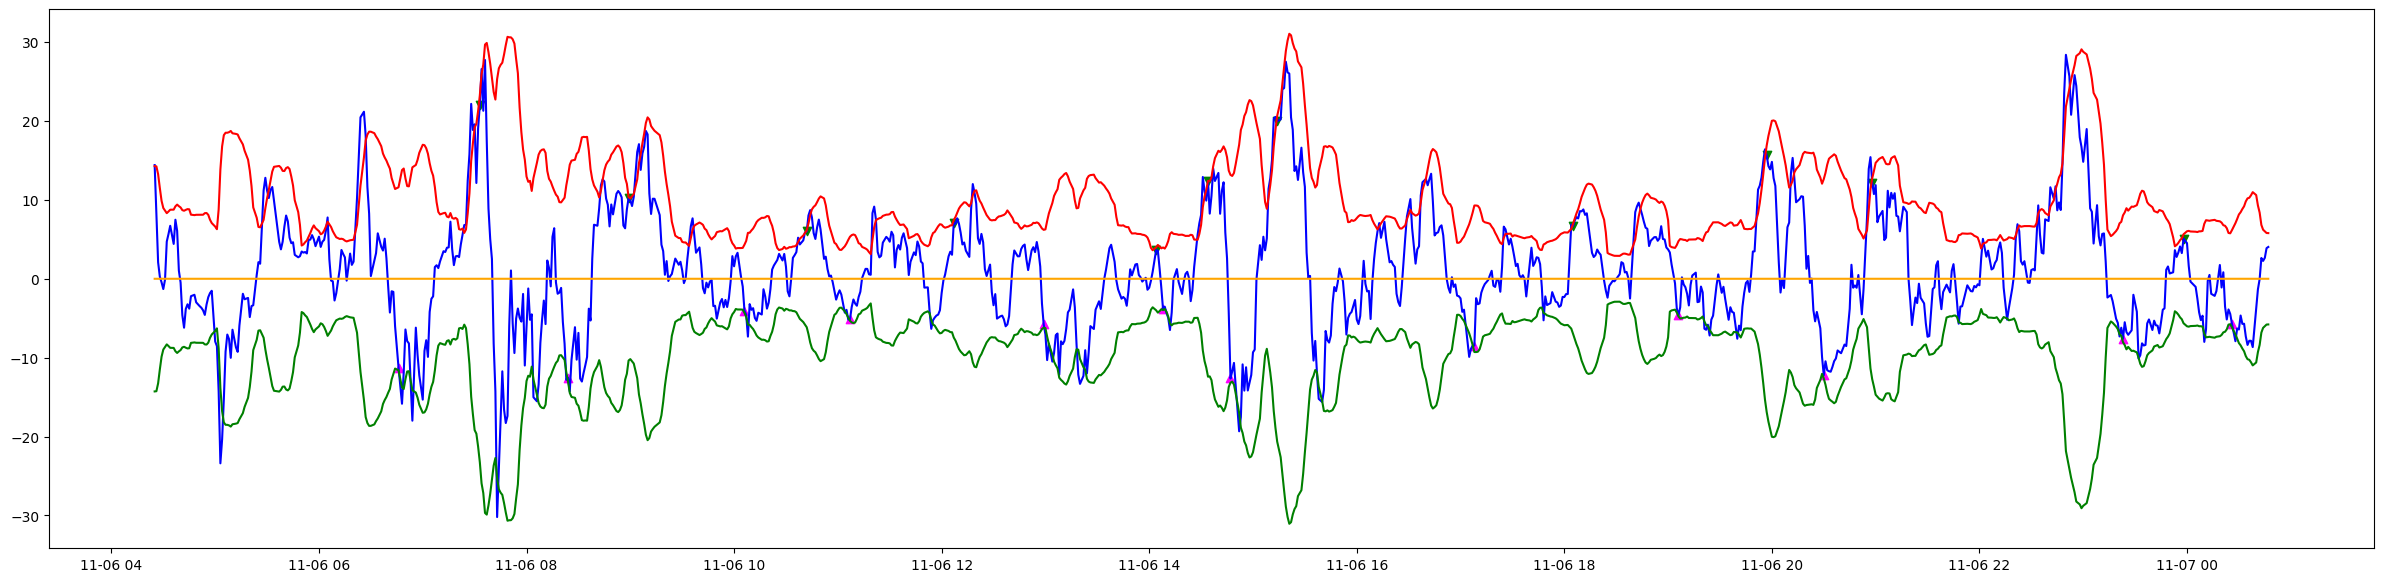

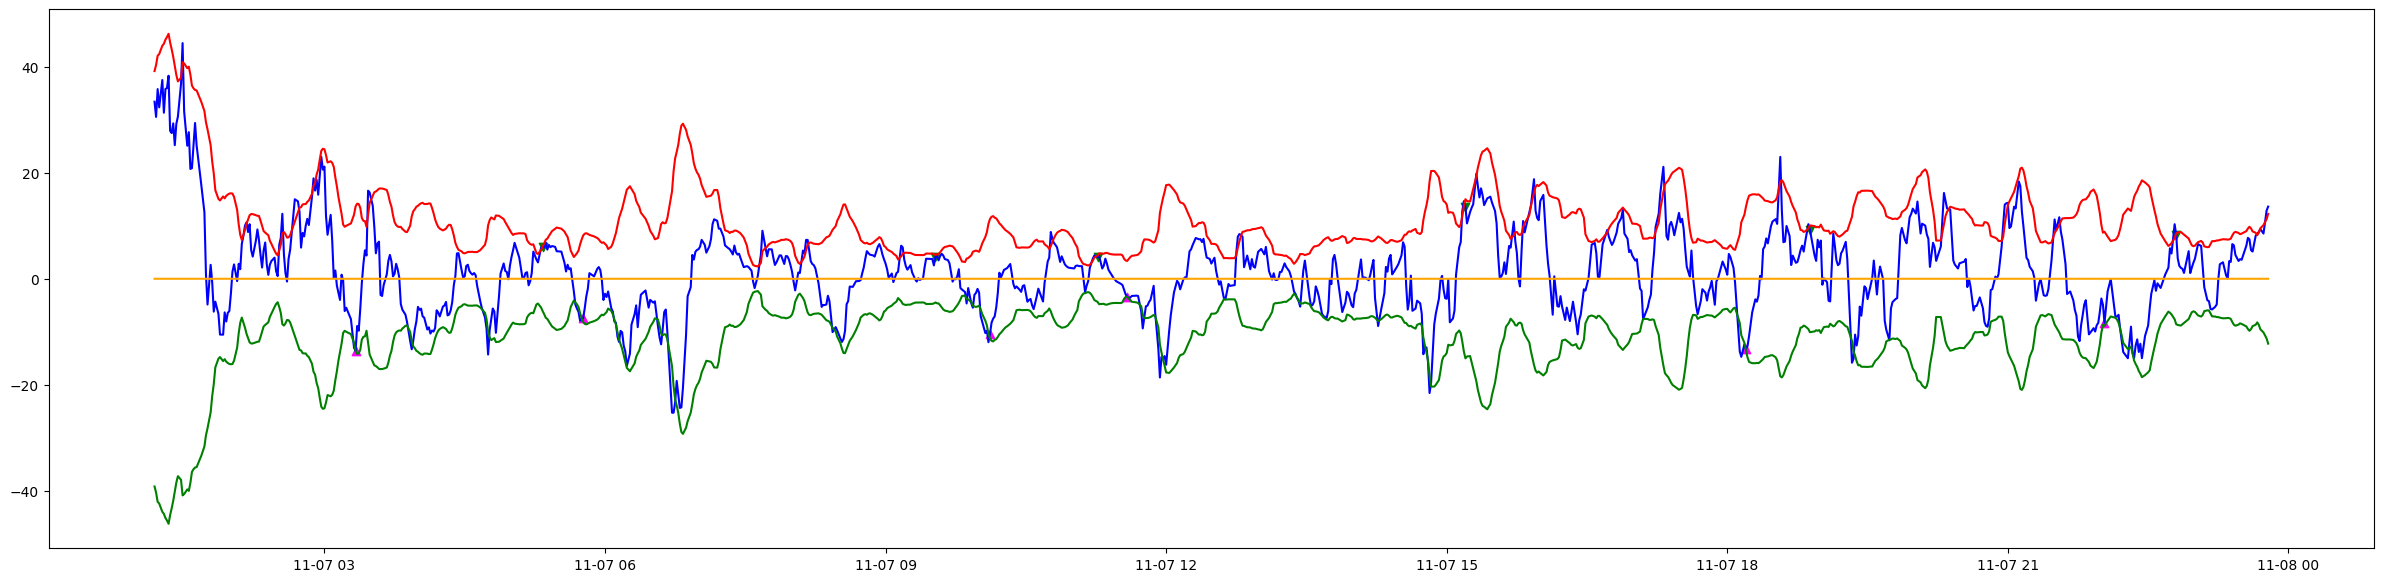

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


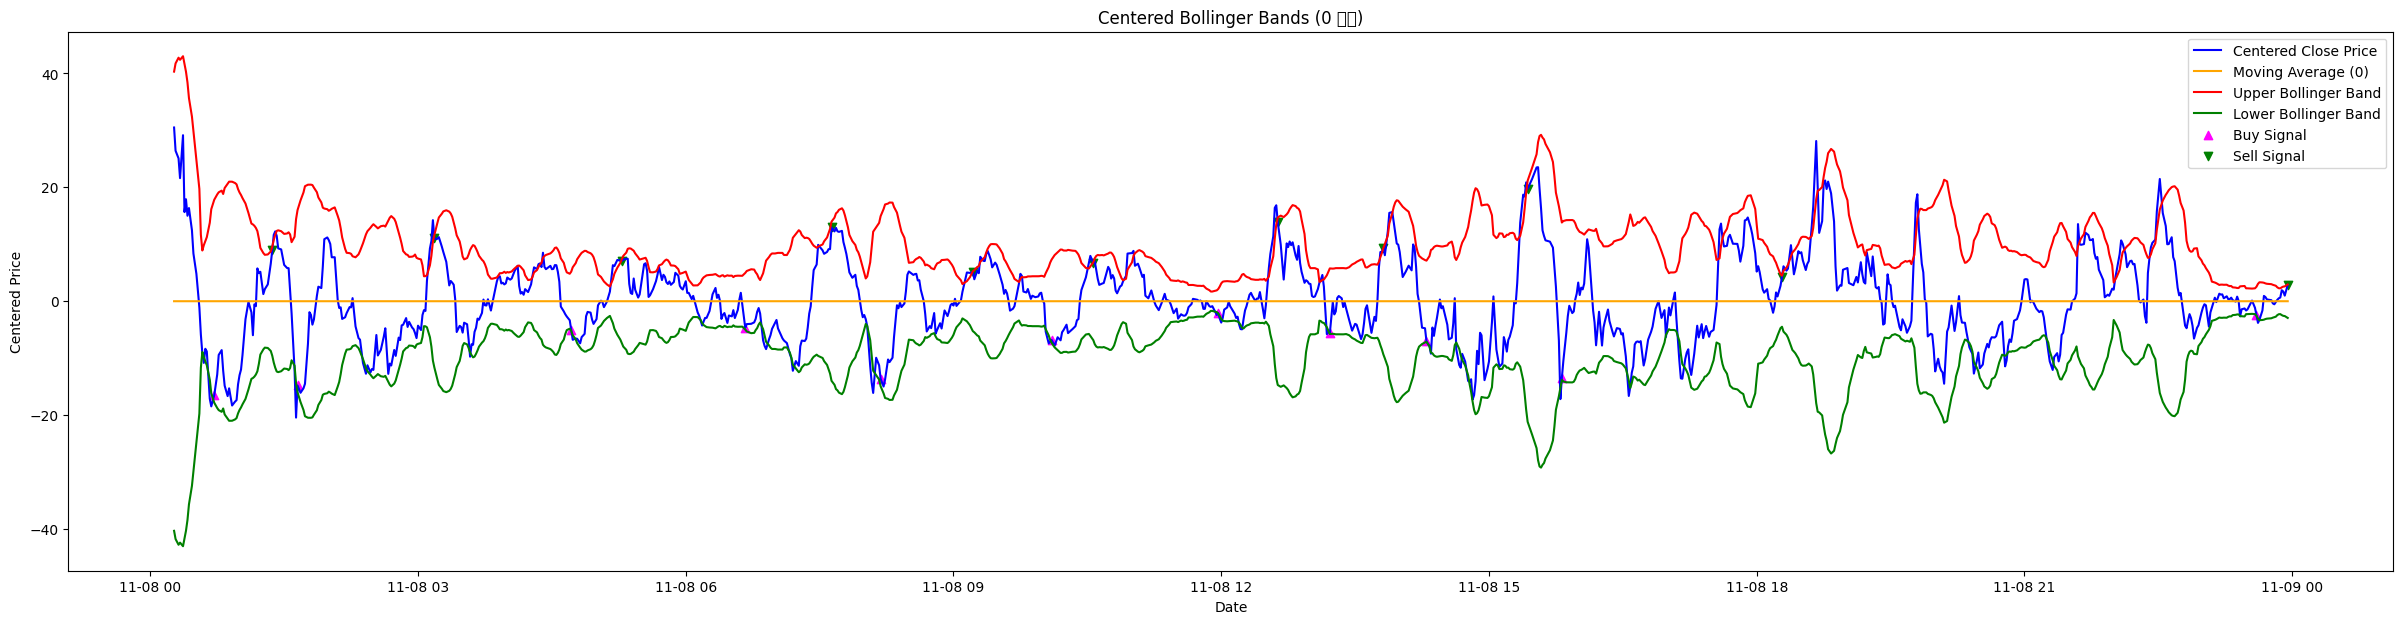

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

for chunk in range(len(chunk_eth)):
    # 데이터 불러오기 (예시)
    data_chunk = chunk_eth[chunk].copy()

    # 이동 평균과 표준 편차 계산
    window = 20
    data_chunk[('Moving_Avg', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).mean()
    data_chunk[('Std_Dev', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).std()

    # NaN 제거 후 볼린저 밴드 0 기준으로 계산
    data_chunk.dropna(inplace=True)
    data_chunk[('Centered_Close', 'ETH-USD')] = data_chunk[('Close', 'ETH-USD')] - data_chunk[('Moving_Avg', 'ETH-USD')]  # Close에서 이동 평균을 뺀 값
    data_chunk[('Upper_Band', 'ETH-USD')] = data_chunk[('Std_Dev', 'ETH-USD')] * 2
    data_chunk[('Lower_Band', 'ETH-USD')] = -data_chunk[('Std_Dev', 'ETH-USD')] * 2

    close_to_upper = False
    close_to_lower = False

    # 매수 및 매도 전략 수행
    buy_signals = []  # 매수 지점
    sell_signals = []  # 매도 지점
    positions = []  # 각 시간에 따른 포지션 상태 저장 리스트
    position = 0  # 포지션 (1: 매수 상태, 0: 중립, -1: 매도 상태)

    profit = 0
    total_profit = 0
    buy_price = 0


    for i in range(len(data_chunk)):
        centered_close = data_chunk.iloc[i][('Centered_Close', 'ETH-USD')]
        lower_band = data_chunk.iloc[i][('Lower_Band', 'ETH-USD')]
        upper_band = data_chunk.iloc[i][('Upper_Band', 'ETH-USD')]

        # 편차를 계산하여 근접 여부 판단
        deviation_threshold = 0.1  # 편차 임계값 설정 (10%)

        # Lower_Band에 근접했는지 확인
        if abs(centered_close - lower_band) / abs(lower_band) < deviation_threshold:
            close_to_lower = True
        else:
            close_to_lower = False

        # Upper_Band에 근접했는지 확인
        if abs(centered_close - upper_band) / abs(upper_band) < deviation_threshold:
            close_to_upper = True
        else:
            close_to_upper = False

        # Lower_Band에 근접했다가 떨어지는 경우 매수
        if position == 0 and close_to_lower and centered_close > lower_band:
            position = 1  # 매수
            buy_signals.append((data_chunk.index[i], centered_close))
            print(f"Buy signal at index {data_chunk.index[i]} with value {centered_close}")
            buy_price = centered_close
        # Upper_Band에 근접했다가 떨어지는 경우 매도
        elif position == 1 and close_to_upper and centered_close < upper_band:
            position = 0  # 매도
            sell_signals.append((data_chunk.index[i], centered_close))
            profit = (centered_close - buy_price)
            total_profit += profit
            buy_price = 0
            print(f"Sell signal at index {data_chunk.index[i]} with value {centered_close} for {profit} total : {total_profit}")
        # 포지션 중립 상태 유지

        # 포지션 저장
        positions.append(position)

    plt.figure(figsize=(30, 7))
    # 그래프 그리기
    plt.plot(data_chunk.index, data_chunk[('Centered_Close', 'ETH-USD')], label='Centered Close Price', color='blue')
    plt.plot(data_chunk.index, [0] * len(data_chunk), label='Moving Average (0)', color='orange')
    plt.plot(data_chunk.index, data_chunk[('Upper_Band', 'ETH-USD')], label='Upper Bollinger Band', color='red')
    plt.plot(data_chunk.index, data_chunk[('Lower_Band', 'ETH-USD')], label='Lower Bollinger Band', color='green')
    plt.scatter(*zip(*buy_signals), color='magenta', label='Buy Signal', marker='^')  # 매수 지점 표시
    plt.scatter(*zip(*sell_signals), color='green', label='Sell Signal', marker='v')  # 매도 지점 표시

    # 매수 및 매도 시그널 개수 출력
    print(f"Number of buy signals: {len(buy_signals)}")
    print(f"Number of sell signals: {len(sell_signals)}")

# 그래프 타이틀과 레이블
plt.title('Centered Bollinger Bands (0 기준)')
plt.xlabel('Date')
plt.ylabel('Centered Price')
plt.legend(loc='best')
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


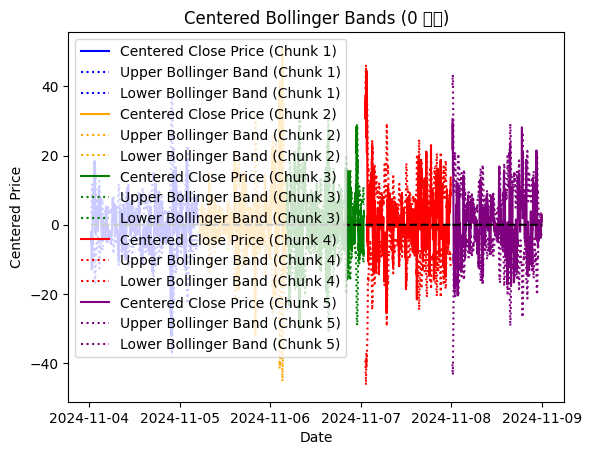

In [79]:
import matplotlib.pyplot as plt
import pandas as pd

# 색상 리스트를 정의하여 청크별로 다른 색을 사용
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for chunk in range(len(chunk_eth)):
    # 데이터 불러오기 (예시)
    data_chunk = chunk_eth[chunk].copy()

    # 이동 평균과 표준 편차 계산
    window = 20
    data_chunk[('Moving_Avg', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).mean()
    data_chunk[('Std_Dev', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).std()

    # NaN 제거 후 볼린저 밴드 0 기준으로 계산
    data_chunk.dropna(inplace=True)
    data_chunk[('Centered_Close', 'ETH-USD')] = data_chunk[('Close', 'ETH-USD')] - data_chunk[('Moving_Avg', 'ETH-USD')]  # Close에서 이동 평균을 뺀 값
    data_chunk[('Upper_Band', 'ETH-USD')] = data_chunk[('Std_Dev', 'ETH-USD')] * 2
    data_chunk[('Lower_Band', 'ETH-USD')] = -data_chunk[('Std_Dev', 'ETH-USD')] * 2

    # 그래프 그리기 - 각 청크마다 다른 색상 사용
    color = colors[chunk % len(colors)]  # 색상 리스트를 순환하여 사용
    plt.plot(data_chunk.index, data_chunk[('Centered_Close', 'ETH-USD')], label=f'Centered Close Price (Chunk {chunk + 1})', color=color)
    plt.plot(data_chunk.index, [0] * len(data_chunk), color='black', linestyle='--')  # 0 기준선은 검은색 점선으로 통일
    plt.plot(data_chunk.index, data_chunk[('Upper_Band', 'ETH-USD')], label=f'Upper Bollinger Band (Chunk {chunk + 1})', color=color, linestyle=':')
    plt.plot(data_chunk.index, data_chunk[('Lower_Band', 'ETH-USD')], label=f'Lower Bollinger Band (Chunk {chunk + 1})', color=color, linestyle=':')

# 그래프 타이틀과 레이블
plt.title('Centered Bollinger Bands (0 기준)')
plt.xlabel('Date')
plt.ylabel('Centered Price')
plt.legend(loc='best')
plt.show()


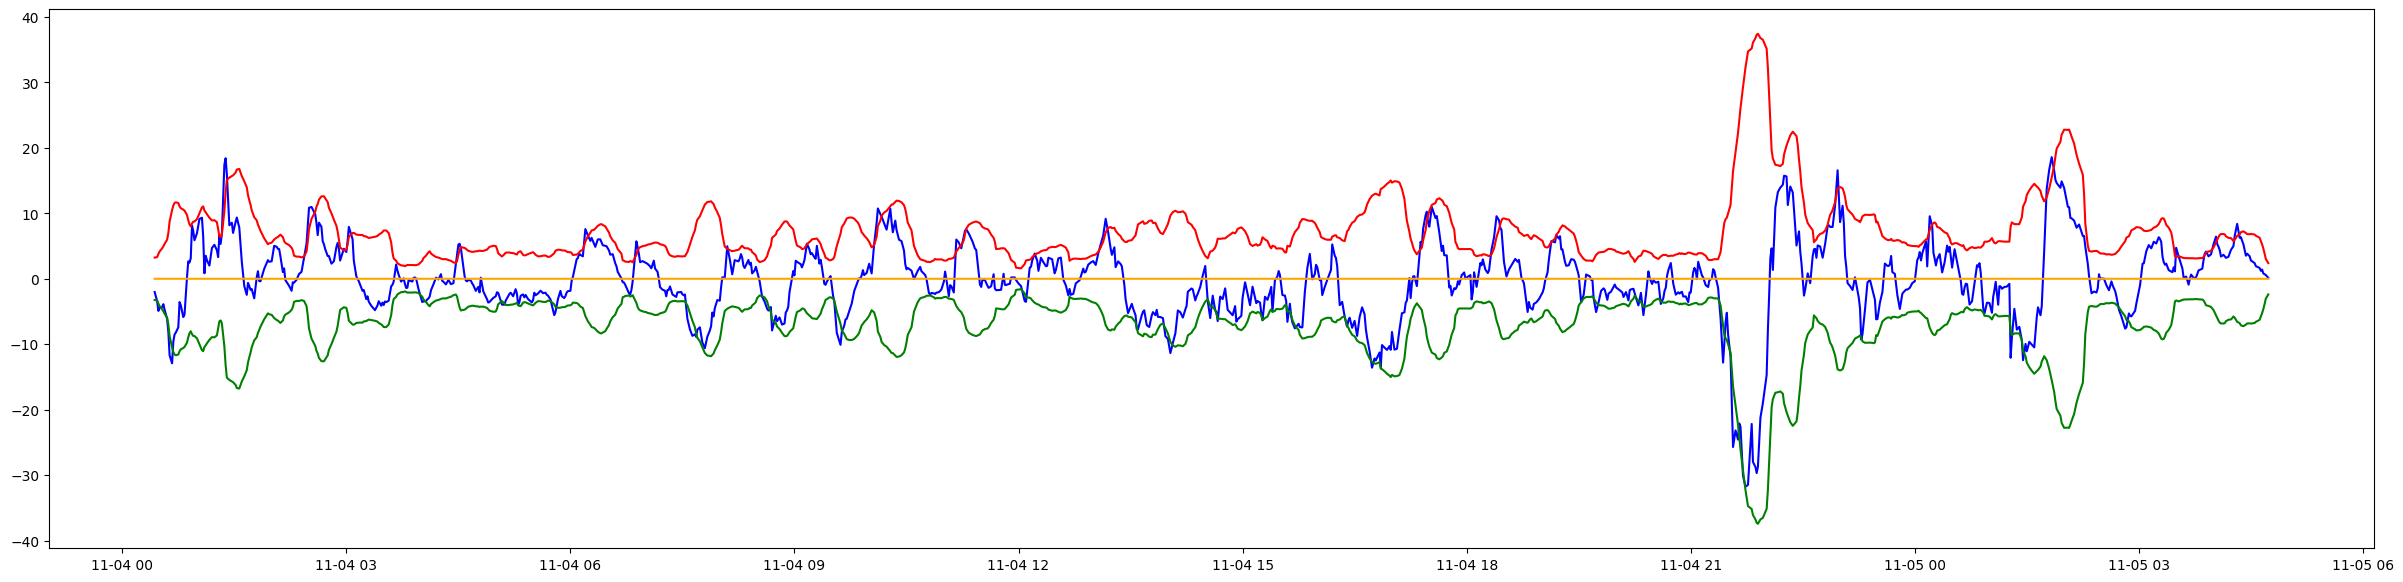

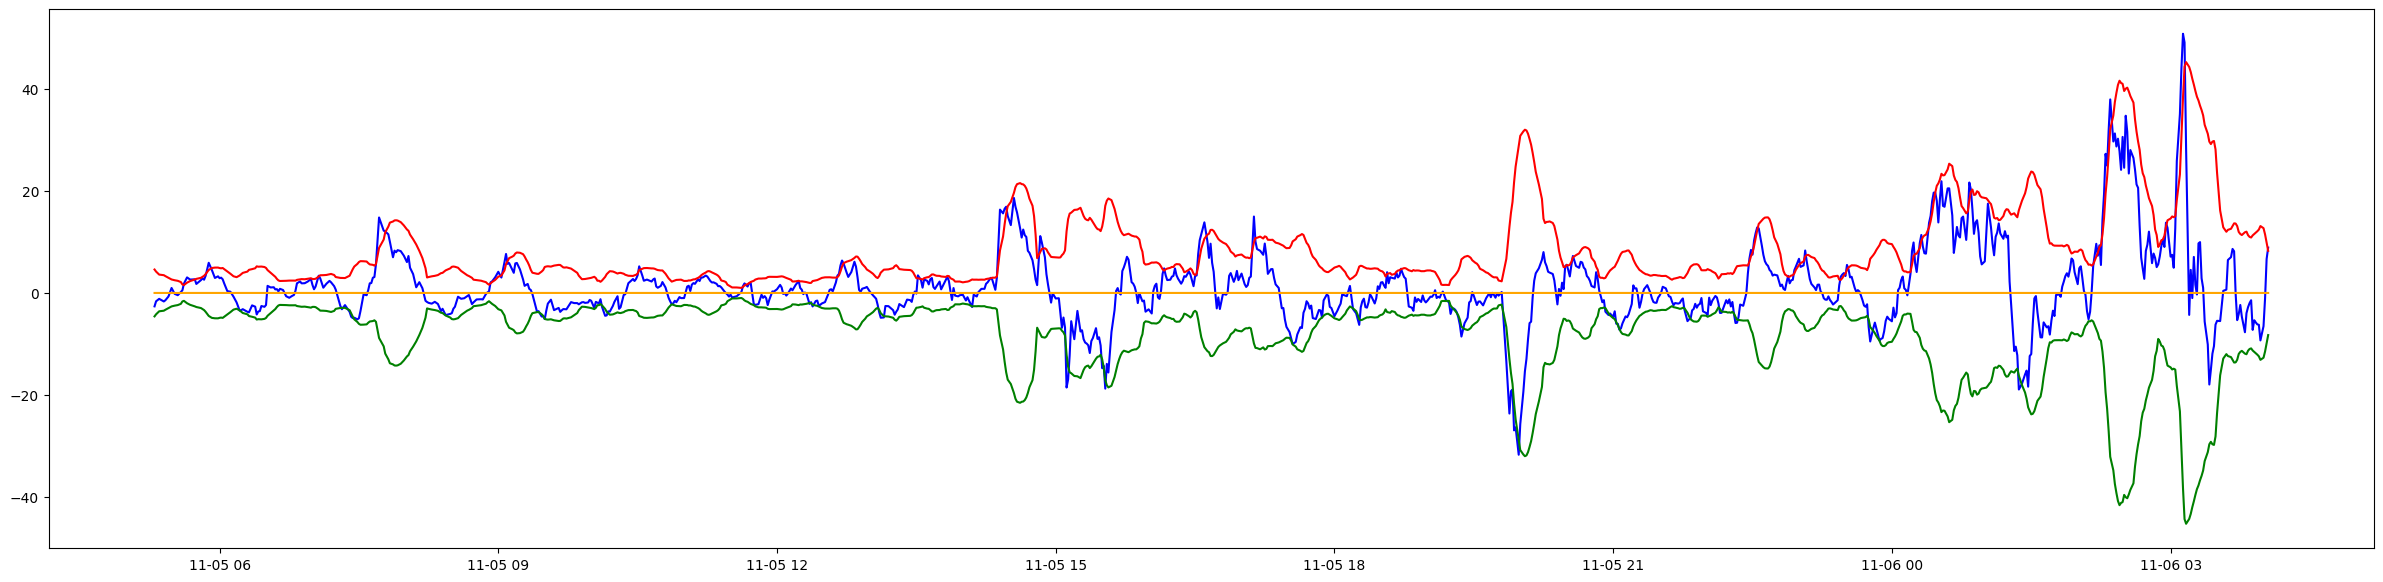

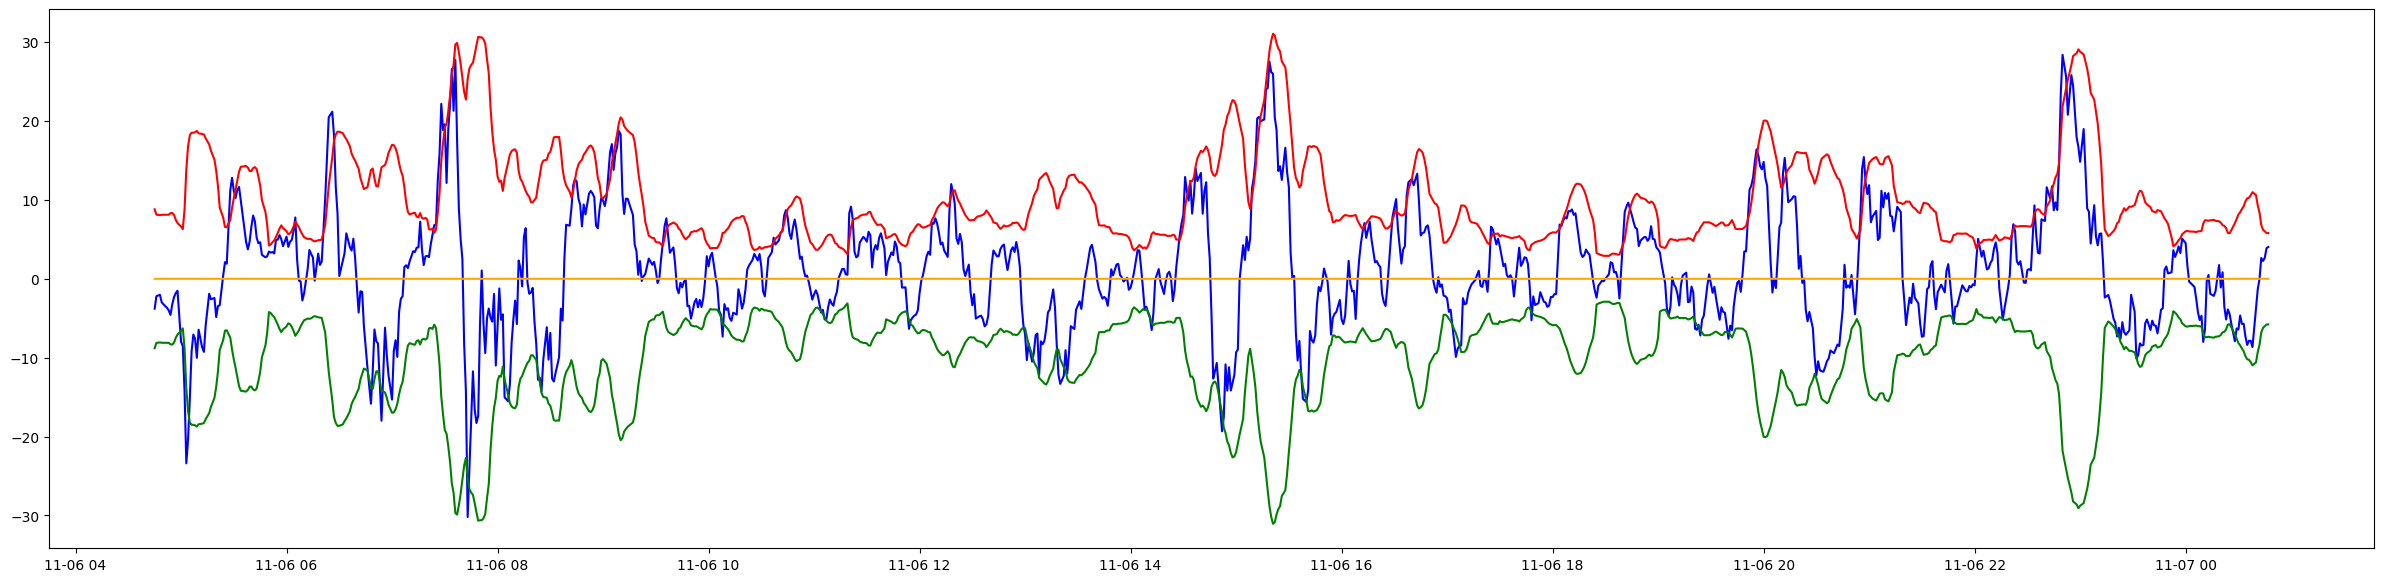

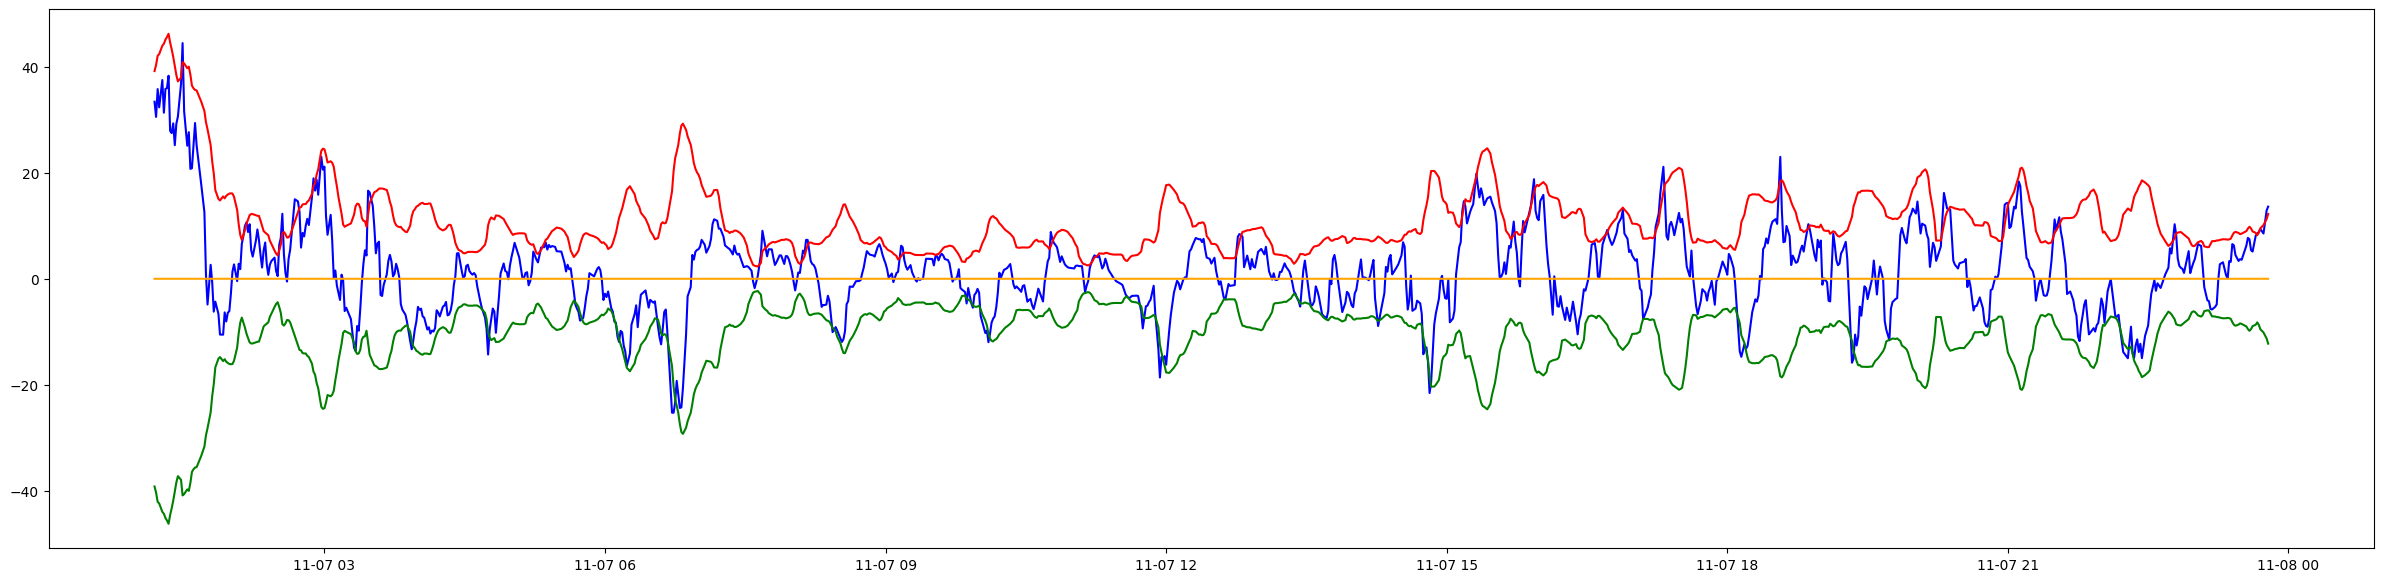

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


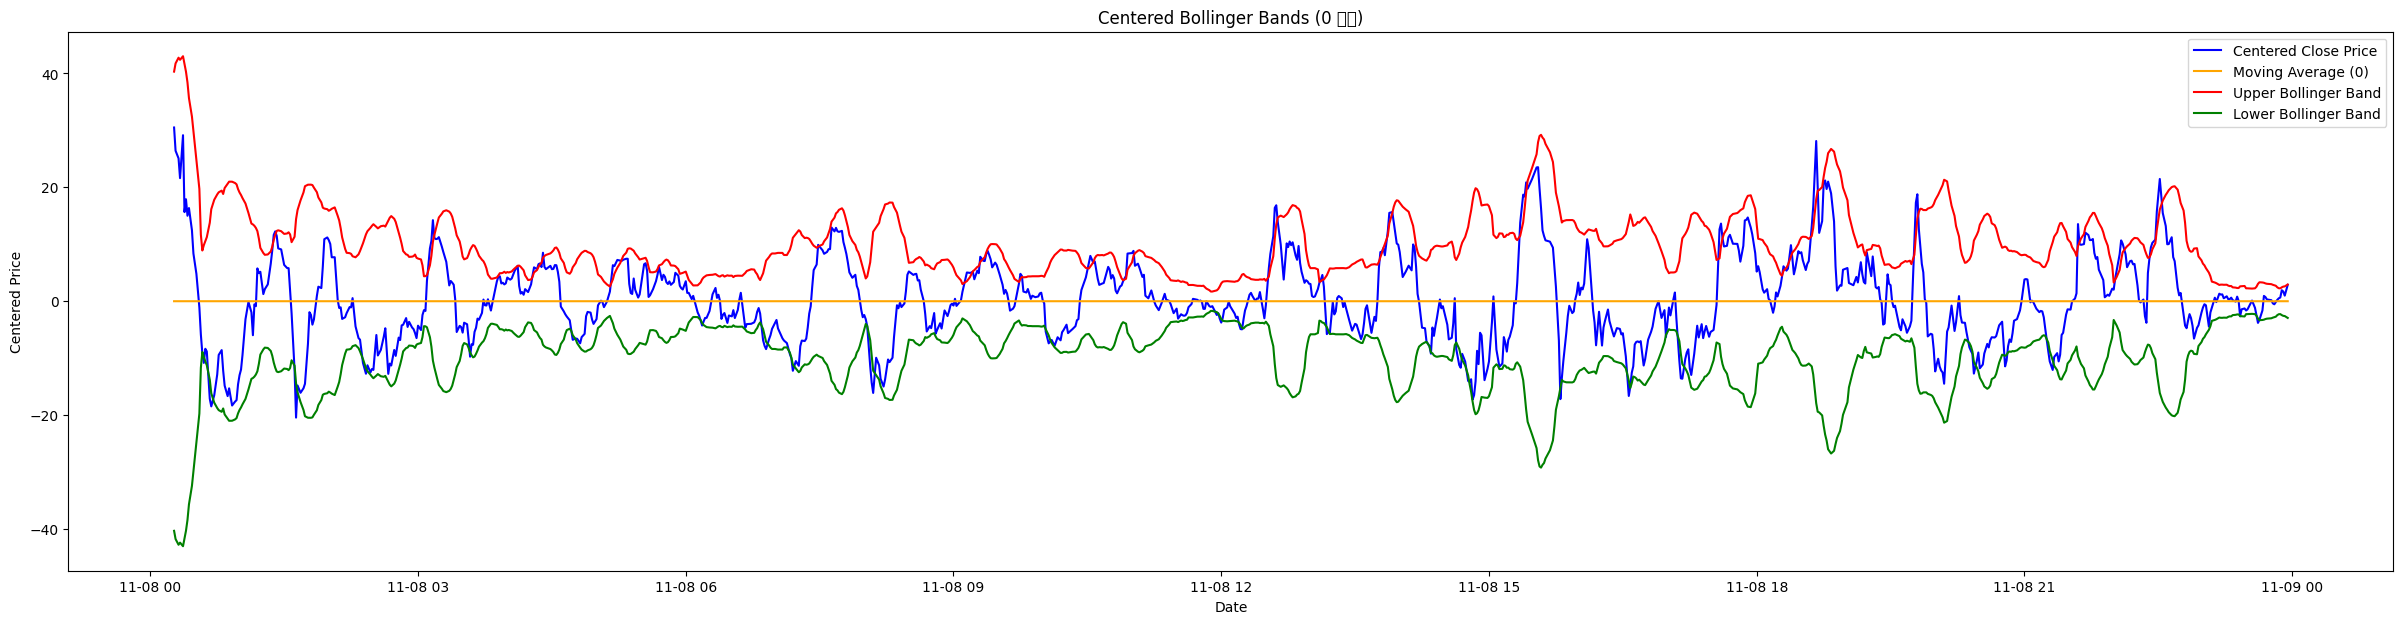

In [16]:
import matplotlib.pyplot as plt
import pandas as pd


for chunk in range(len(chunk_eth)):
  # 데이터 불러오기 (예시)
  data_chunk = chunk_eth[chunk].copy()

  # 이동 평균과 표준 편차 계산
  window = 20
  data_chunk[('Moving_Avg', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).mean()
  data_chunk[('Std_Dev', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).std()


  # NaN 제거 후 볼린저 밴드 0 기준으로 계산
  data_chunk.dropna(inplace=True)
  data_chunk[('Centered_Close', 'ETH-USD')] = data_chunk[('Close', 'ETH-USD')] - data_chunk[('Moving_Avg', 'ETH-USD')]  # Close에서 이동 평균을 뺀 값
  data_chunk[('Upper_Band', 'ETH-USD')] = data_chunk[('Std_Dev', 'ETH-USD')] * 2
  data_chunk[('Lower_Band', 'ETH-USD')] = -data_chunk[('Std_Dev', 'ETH-USD')] * 2


  plt.figure(figsize=(30, 7))
  # 그래프 그리기
  plt.plot(data_chunk.index, data_chunk[('Centered_Close', 'ETH-USD')], label='Centered Close Price', color='blue')
  plt.plot(data_chunk.index, [0] * len(data_chunk), label='Moving Average (0)', color='orange')
  plt.plot(data_chunk.index, data_chunk[('Upper_Band', 'ETH-USD')], label='Upper Bollinger Band', color='red')
  plt.plot(data_chunk.index, data_chunk[('Lower_Band', 'ETH-USD')], label='Lower Bollinger Band', color='green')

# 그래프 타이틀과 레이블
plt.title('Centered Bollinger Bands (0 기준)')
plt.xlabel('Date')
plt.ylabel('Centered Price')
plt.legend(loc='best')
plt.show()


KeyError: Timestamp('2024-11-04 00:28:00+0000', tz='UTC')

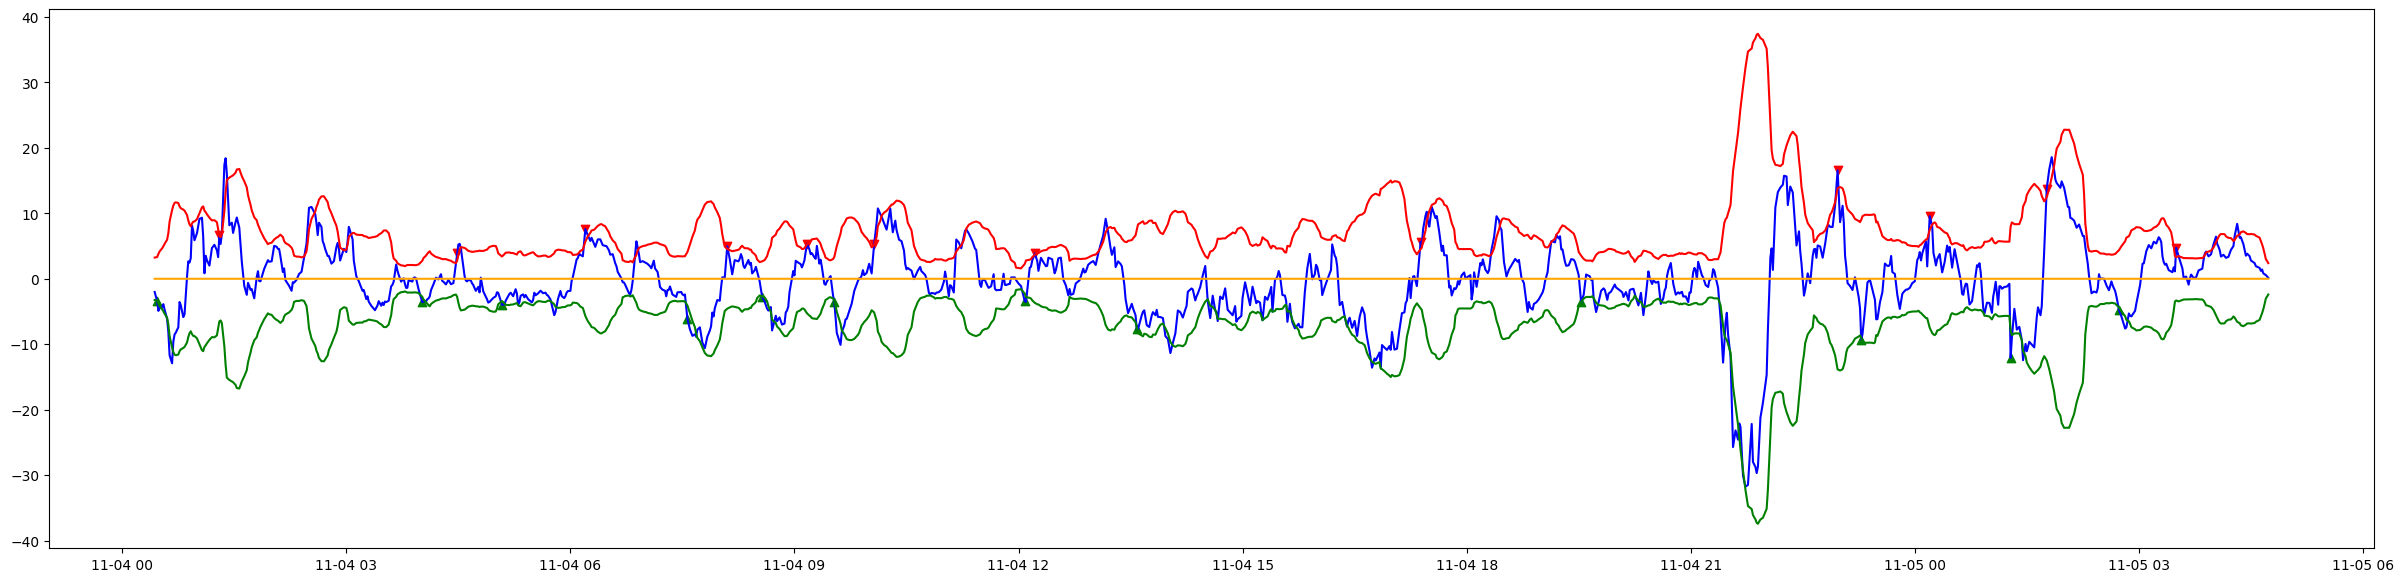

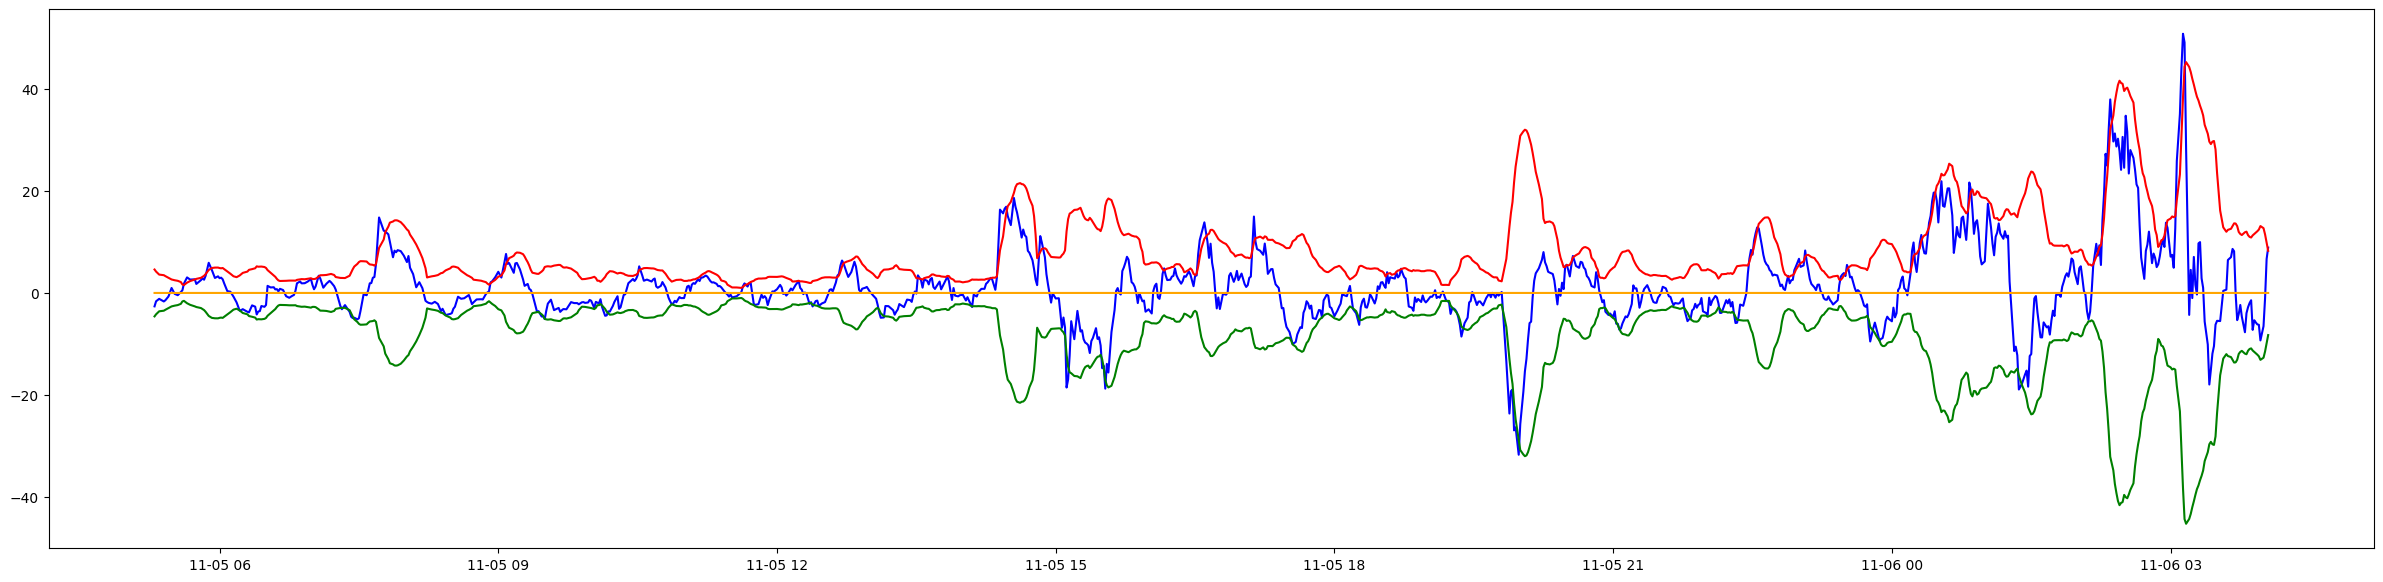

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

position = 0  # 포지션 (1: 매수 상태, 0: 중립, -1: 매도 상태)
positions = []  # 각 시간에 따른 포지션 상태 저장 리스트
buy_signals = []  # 매수 지점 저장 리스트
sell_signals = []  # 매도 지점 저장 리스트

def save_trade_signals(i, position, buy_signals, sell_signals):
    if position == 1:
        buy_signals.append(i)
    elif position == -1:
        sell_signals.append(i)

for chunk in range(len(chunk_eth)):
    # 데이터 불러오기 (예시)
    data_chunk = chunk_eth[chunk].copy()

    # 이동 평균과 표준 편차 계산
    window = 20
    data_chunk[('Moving_Avg', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).mean()
    data_chunk[('Std_Dev', "ETH-USD")] = data_chunk[('Close', "ETH-USD")].rolling(window=window).std()

    # NaN 제거 후 볼린저 밴드 0 기준으로 계산
    data_chunk.dropna(inplace=True)
    data_chunk[('Centered_Close', 'ETH-USD')] = data_chunk[('Close', 'ETH-USD')] - data_chunk[('Moving_Avg', 'ETH-USD')]  # Close에서 이동 평균을 뺀 값
    data_chunk[('Upper_Band', 'ETH-USD')] = data_chunk[('Std_Dev', 'ETH-USD')] * 2
    data_chunk[('Lower_Band', 'ETH-USD')] = -data_chunk[('Std_Dev', 'ETH-USD')] * 2

    # 매수 및 매도 전략 수행
    for i in range(len(data_chunk)):
        centered_close = data_chunk.iloc[i][('Centered_Close', 'ETH-USD')]
        lower_band = data_chunk.iloc[i][('Lower_Band', 'ETH-USD')]
        upper_band = data_chunk.iloc[i][('Upper_Band', 'ETH-USD')]

        # 오차 범위가 Lower_Band에 붙어있다가 떨어지는 경우 매수
        if position == 0 and centered_close <= lower_band:
            position = 1  # 매수
            save_trade_signals(data_chunk.index[i], position, buy_signals, sell_signals)
        # 오차 범위가 Upper_Band에 붙어있다가 아래로 떨어지는 경우 매도
        elif position == 1 and centered_close >= upper_band:
            position = -1  # 매도
            save_trade_signals(data_chunk.index[i], position, buy_signals, sell_signals)
            position = 0  # 매도 후 다시 중립 상태로 복귀

        # 포지션 저장
        positions.append(position)

    plt.figure(figsize=(30, 7))
    # 그래프 그리기
    plt.plot(data_chunk.index, data_chunk[('Centered_Close', 'ETH-USD')], label='Centered Close Price', color='blue')
    plt.plot(data_chunk.index, [0] * len(data_chunk), label='Moving Average (0)', color='orange')
    plt.plot(data_chunk.index, data_chunk[('Upper_Band', 'ETH-USD')], label='Upper Bollinger Band', color='red')
    plt.plot(data_chunk.index, data_chunk[('Lower_Band', 'ETH-USD')], label='Lower Bollinger Band', color='green')

    # 매수 및 매도 지점을 scatter로 표시
    if buy_signals:
        plt.scatter(buy_signals, [data_chunk.loc[idx][('Centered_Close', 'ETH-USD')] for idx in buy_signals], label='Buy Signal', color='green', marker='^', alpha=1)
    if sell_signals:
        plt.scatter(sell_signals, [data_chunk.loc[idx][('Centered_Close', 'ETH-USD')] for idx in sell_signals], label='Sell Signal', color='red', marker='v', alpha=1)

# 그래프 타이틀과 레이블
plt.title('Centered Bollinger Bands (0 기준)')
plt.xlabel('Date')
plt.ylabel('Centered Price')
plt.legend(loc='best')
plt.show()


<ipython-input-155-7a00188b24cb>:29: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


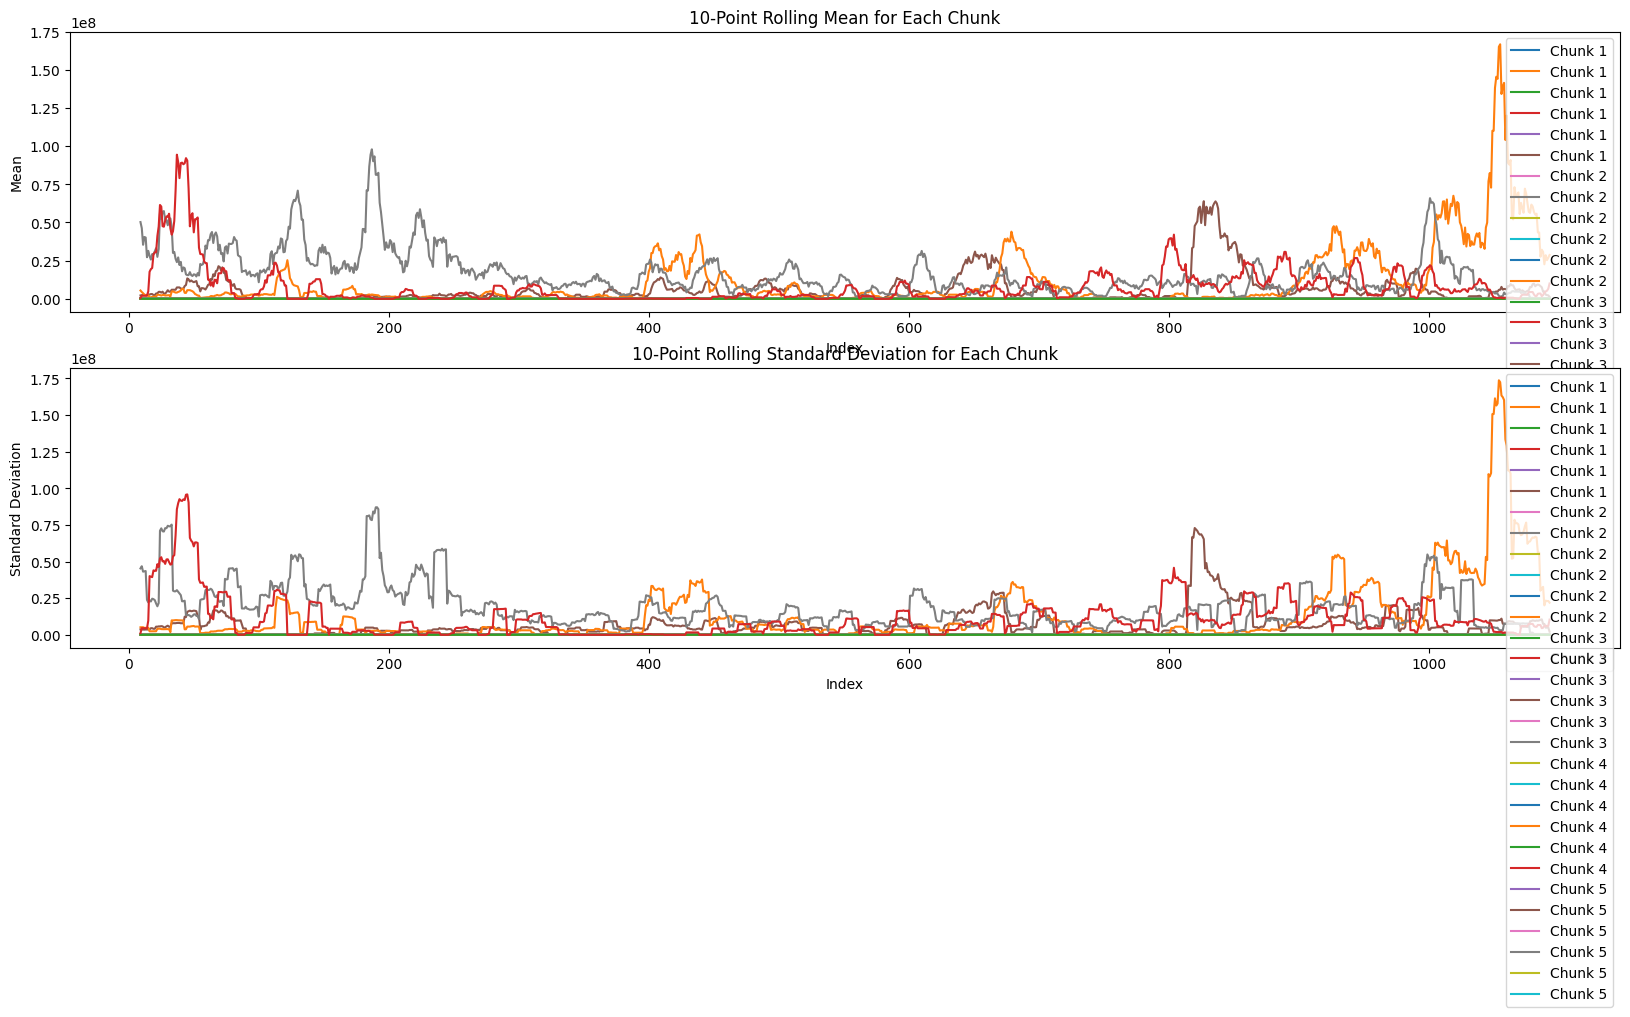

In [155]:
import matplotlib.pyplot as plt

# 예시 데이터에서 chunks가 있는 경우 실행
# chunks = [chunk1, chunk2, chunk3] 형식으로 각 청크의 데이터를 준비합니다.

# 청크별 평균과 표준편차를 구합니다.
chunk_means = [chunk.rolling(window=10).mean().values for chunk in chunks]
chunk_stds = [chunk.rolling(window=10).std().values for chunk in chunks]

# 각 청크의 10개 구간 평균과 표준편차 비교 그래프 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))

# 평균값 그래프
for i, mean_values in enumerate(chunk_means):
    ax1.plot(mean_values, label=f'Chunk {i+1}')
ax1.set_title('10-Point Rolling Mean for Each Chunk')
ax1.set_xlabel('Index')
ax1.set_ylabel('Mean')
ax1.legend()

# 표준편차 그래프
for i, std_values in enumerate(chunk_stds):
    ax2.plot(std_values, label=f'Chunk {i+1}')
ax2.set_title('10-Point Rolling Standard Deviation for Each Chunk')
ax2.set_xlabel('Index')
ax2.set_ylabel('Standard Deviation')
ax2.legend()

plt.tight_layout()
plt.show()


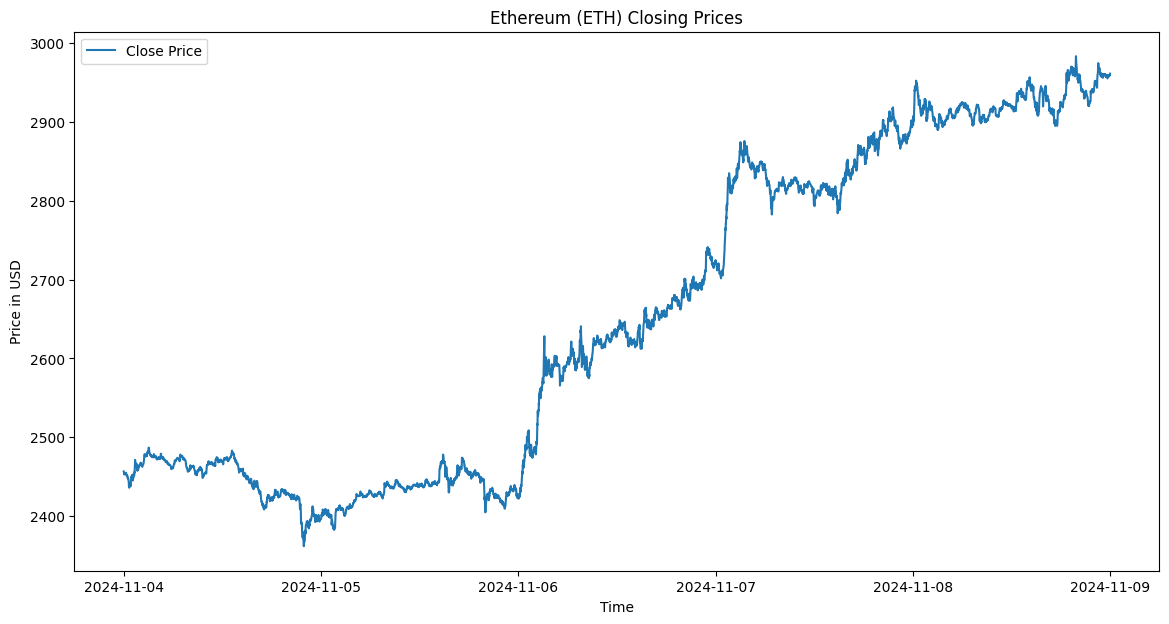

In [122]:
import matplotlib.pyplot as plt

# Plotting the closing prices
plt.figure(figsize=(14, 7))
plt.plot(eth_data['Close'], label='Close Price')
plt.title('Ethereum (ETH) Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

<ipython-input-156-de5901ecd132>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_chunk['Moving_Avg'] = data_chunk['Close'].rolling(window=window).mean()
<ipython-input-156-de5901ecd132>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_chunk['Std_Dev'] = data_chunk['Close'].rolling(window=window).std()
<ipython-input-156-de5901ecd132>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Price                        Adj Close        Close         High          Low  \
Ticker                         ETH-USD      ETH-USD      ETH-USD      ETH-USD   
Datetime                                                                        
2024-11-07 00:43:00+00:00  2710.842773  2710.842773  2710.842773  2710.842773   
2024-11-07 00:44:00+00:00  2710.256836  2710.256836  2710.256836  2710.256836   
2024-11-07 00:45:00+00:00  2710.564209  2710.564209  2710.564209  2710.564209   
2024-11-07 00:46:00+00:00  2711.718262  2711.718262  2711.718262  2711.718262   
2024-11-07 00:47:00+00:00  2711.865967  2711.865967  2711.865967  2711.865967   

Price                             Open   Volume   Moving_Avg   Std_Dev  \
Ticker                         ETH-USD  ETH-USD      ETH-USD   ETH-USD   
Datetime                                                                 
2024-11-07 00:43:00+00:00  2710.842773        0  2708.206067  3.410307   
2024-11-07 00:44:00+00:00  2710.256836        0  2707.9

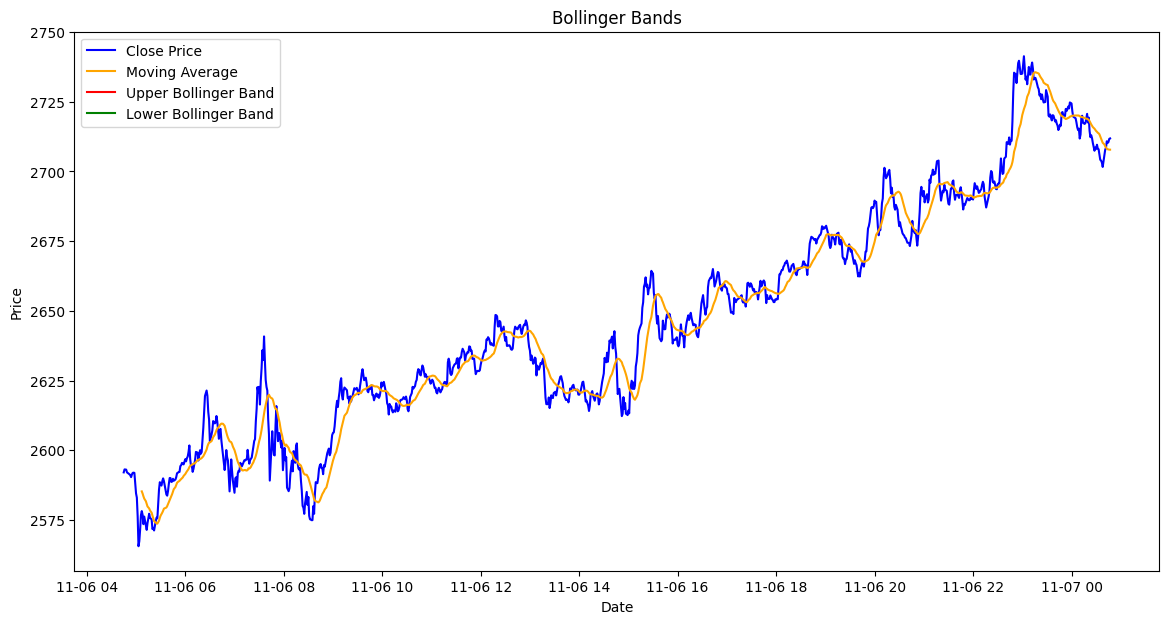

In [156]:
import matplotlib.pyplot as plt
import pandas as pd

# 첫 번째 청크 선택
data_chunk = chunk_eth[2]

# 이동 평균과 표준 편차 계산
window = 20  # 보통 20일 이동 평균을 사용
data_chunk['Moving_Avg'] = data_chunk['Close'].rolling(window=window).mean()
data_chunk['Std_Dev'] = data_chunk['Close'].rolling(window=window).std()

# 볼린저 밴드 계산
data_chunk['Upper_Band'] = data_chunk['Moving_Avg'] + (data_chunk['Std_Dev'] * 2)
data_chunk['Lower_Band'] = data_chunk['Moving_Avg'] - (data_chunk['Std_Dev'] * 2)

print(data_chunk.tail())

# 그래프 그리기
plt.figure(figsize=(14, 7))
plt.plot(data_chunk['Close'], label='Close Price', color='blue')
plt.plot(data_chunk['Moving_Avg'], label='Moving Average', color='orange')
plt.plot(data_chunk['Upper_Band'], label='Upper Bollinger Band', color='red')
plt.plot(data_chunk['Lower_Band'], label='Lower Bollinger Band', color='green')
plt.fill_between(data_chunk.index, data_chunk['Upper_Band'], data_chunk['Lower_Band'], color='grey', alpha=0.1)

# 그래프 타이틀과 레이블
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()


<ipython-input-86-7d8cb9c86cbb>:29: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


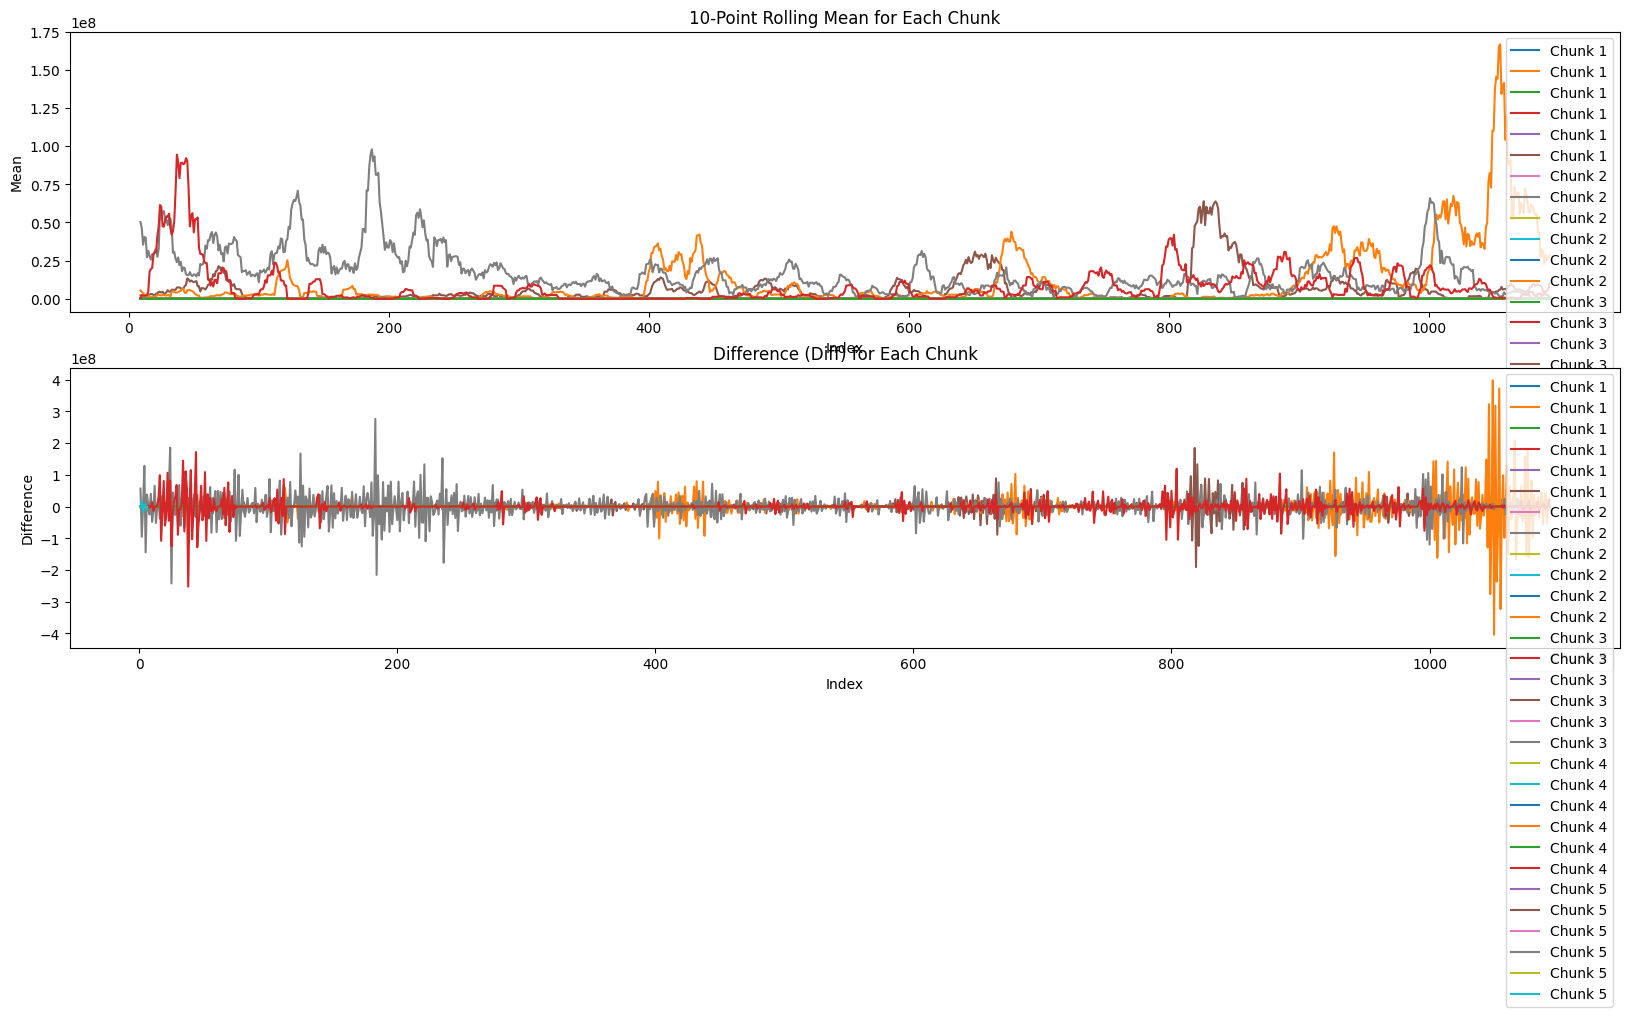

In [86]:
import matplotlib.pyplot as plt

# 예시 데이터에서 chunks가 있는 경우 실행
# chunks = [chunk1, chunk2, chunk3] 형식으로 각 청크의 데이터를 준비합니다.

# 청크별 평균과 차이값(diff)을 구합니다.
chunk_means = [chunk.rolling(window=10).mean().values for chunk in chunks]
chunk_diffs = [chunk.diff().values for chunk in chunks]

# 각 청크의 10개 구간 평균과 차이값(diff) 비교 그래프 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8))

# 평균값 그래프
for i, mean_values in enumerate(chunk_means):
    ax1.plot(mean_values, label=f'Chunk {i+1}')
ax1.set_title('10-Point Rolling Mean for Each Chunk')
ax1.set_xlabel('Index')
ax1.set_ylabel('Mean')
ax1.legend()

# 차이값(diff) 그래프
for i, diff_values in enumerate(chunk_diffs):
    ax2.plot(diff_values, label=f'Chunk {i+1}')
ax2.set_title('Difference (Diff) for Each Chunk')
ax2.set_xlabel('Index')
ax2.set_ylabel('Difference')
ax2.legend()

plt.tight_layout()
plt.show()
